In [1]:
import sys
# sys.path.append("./subroutines")
sys.path.append("./Vertex/subroutines")

from GAMcalc import *  # Code for calculating vertex functions
import propagator  # propagator object used to store pre-calculated values
import wignerD as wd # wigner D object used to store pre-calculated values

pset=propagator.prop_set(nlam=10) 
wigset = wd.wigner_d_vals()

# ABS/ Solvent effects comparison

In [2]:
import ABS_vertex_calc as abs

In [3]:
ID = 23457.04

# looping = "full mark dens comp alt f_bind,"

settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\binder_diblock\ID=%s_settings.npy" % (ID), allow_pickle = True)

[chrom, [klog_min, klog_max, klog_num]] = settings

# [n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
[n_bind, v_int, Vol_int, e_m, rho_p, rho_s, poly_marks, M, mu_max, mu_min, del_mu, alpha, N, N_m, b] = chrom

[pa_vec, marks_2] = poly_marks

mu1_array = np.arange(mu_min, mu_max, del_mu)
mu2_array = np.arange(mu_min, mu_max, del_mu)

k_vec = np.logspace(klog_min, klog_max, klog_num) / b
  
# s2_mats = np.load(r"C:\Users\tmhab\wlcsim_membrane\binder_diblock\ID=%s_chrom_s2_mats_v_int=[[%s,%s],[%s,%s]],diblock,mu_max=%s.npy"\
#                  % (ID, v_int[0,0], v_int[0,1], v_int[1,0], v_int[1,1], mu_max), allow_pickle = True)

s_bind_A_arr = np.load(r"ID=%s_s_bind_A.npy" % ID, allow_pickle=True)
s_bind_B_arr = np.load(r"ID=%s_s_bind_B.npy" % ID, allow_pickle=True)
spacing = int(1 / del_mu)


print("rho_p (# / nm^3): ", rho_p)
print("rho_s (# / nm^3): ", alpha * rho_p/ M)
print("M: ", M)
print("N: ", N)
print("b: ", b)

print("mu1 array:", mu1_array)
print("v_int: ", v_int)

print("k_vec array:", k_vec)


phi_p = 0.8
A = 1
v_s = A*b
vol_terms = [phi_p, A, v_s]



rho_p (# / nm^3):  3.0100000000000006e-09
rho_s (# / nm^3):  63.99999980736
M:  50
N:  50000
b:  1
mu1 array: [-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5]
v_int:  [[-4  4]
 [ 4 -4]]
k_vec array: [0.00316228 0.00356225 0.00401281 0.00452035 0.0050921  0.00573615
 0.00646167 0.00727895 0.00819961 0.00923671 0.01040498 0.01172102
 0.01320352 0.01487352 0.01675475 0.01887392 0.02126112 0.02395027
 0.02697954 0.03039195 0.03423598 0.0385662  0.04344412 0.04893901
 0.0551289  0.06210169 0.06995642 0.07880463 0.08877197 0.1       ]


In [4]:
FA = 0.3
bind_A = np.zeros(M)
bind_A[0:int(M*FA)] = 1
bind_B = 1-bind_A

s_bnd_A = bind_A
s_bnd_B = bind_B



In [5]:
np.sum(bind_A)/len(bind_A)

0.3

In [6]:
KS = spinodal(pset, N, FA)
q_star = KS[0]

lam_q = q_star*np.array([1, 0, 0])
Ks = np.array([lam_q, -lam_q, lam_q, -lam_q])

## spinodal

In [7]:
# confirm that shifans g2 leads to accurate spinodal

### single phi_p

In [32]:
# %%time
# k* stability analysis; single phi_p

chi_array = np.arange(0, 31, 1)/N

FA_array = [0.7, 0.6, 0.5, 0.4, 0.3]

min_eigval_arr = np.zeros((len(FA_array), len(chi_array), len(k_vec)))

min_eigval_arr_allk_DENS = np.zeros((len(FA_array), len(chi_array)))
min_eigval_arr_allk_ps = np.zeros((len(FA_array), len(chi_array)))

min_eigvec_arr = np.zeros((len(FA_array), len(chi_array), len(k_vec), 2))
min_eigvec_arr_allk_DENS = np.zeros((len(FA_array), len(chi_array), 2))

k_star_arr_DENS= np.zeros((len(FA_array), len(chi_array))) 

for i, FA in enumerate(FA_array):
        
    bind_A = np.zeros(M)
    bind_A[0:int(M*FA)] = 1
    bind_B = 1-bind_A
    
    s_bnd_A = bind_A
    s_bnd_B = bind_B
        # print("mu: ", mu)
    for j, CHI in enumerate(chi_array):
        for ik, k in enumerate(k_vec):
            G2_shifan = abs.gamma2_shifan(chrom, s_bnd_A, s_bnd_B, k, CHI, vol_terms)
            val, vec = np.linalg.eigh(G2_shifan)        
            vec = vec.T
            min_val = np.min(val)            
            min_eigval_arr[i][j][ik] = min_val
            min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]
    
    
        # all-k analysis
        # min eigvals, eigvecs at given mu1,mu2 for each k        
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] 
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
    
        # minimum eigenvalue at given mu1,mu2 across all ks
        minval_allk = np.min(min_vals) 
        
        # store this eigenvalue and corresponding eigenvector
        min_eigval_arr_allk_DENS[i][j] = minval_allk 
        min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]
    
        k_star = k_vec[np.where(min_vals==minval_allk)]
        k_star_arr_DENS[i][j] = k_star

# setting all non-decomposed/ separated systems to 0 
psi_1_fluc = min_eigvec_arr_allk_DENS[:,:,0]
psi_1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

psi_2_fluc = min_eigvec_arr_allk_DENS[:,:,1]
psi_2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

chi_star_arr = np.zeros(len(FA_array))
for i, fa_kstar_arr in enumerate(k_star_arr_DENS):
    A = fa_kstar_arr
    m1 = A[:-1]<0 
    m2 = np.sign(A[1:]*A[:-1])==-1
    
    r = np.argwhere(np.all(np.vstack([m1,m2]), axis=0))
    ind = np.squeeze(r).tolist()
    chi_star_arr[i] = chi_array[ind]

In [33]:
chi_star_arr*N

array([18., 14., 13., 14., 18.])

### single phi shifan/binder comparison

In [43]:
# %%time
# k* stability analysis; single phi_p comparison SOLV EFFECTS T

chi_array = np.arange(0, 31, 1)/N

FA_array = [0.7, 0.6, 0.5, 0.4, 0.3]

min_eigval_arr = np.zeros((len(FA_array), len(chi_array), len(k_vec)))

min_eigval_arr_allk_DENS = np.zeros((len(FA_array), len(chi_array)))
min_eigval_arr_allk_ps = np.zeros((len(FA_array), len(chi_array)))

min_eigvec_arr = np.zeros((len(FA_array), len(chi_array), len(k_vec), 2))
min_eigvec_arr_allk_DENS = np.zeros((len(FA_array), len(chi_array), 2))

k_star_arr_DENS_bd = np.zeros((len(FA_array), len(chi_array))) 

for i, FA in enumerate(FA_array):
        
    bind_A = np.zeros(M)
    bind_A[0:int(M*FA)] = 1
    bind_B = 1-bind_A
    
    s_bnd_A = bind_A
    s_bnd_B = bind_B
        # print("mu: ", mu)
    for j, CHI in enumerate(chi_array):
        for ik, k in enumerate(k_vec):
            # G2_shifan = abs.gamma2_shifan(chrom, s_bnd_A, s_bnd_B, k, CHI, vol_terms)
            G2_bd = abs.gamma2_alt_T(chrom, s_bnd_A, s_bnd_B, k, CHI, vol_terms)
            val, vec = np.linalg.eigh(G2_bd)        
            vec = vec.T
            min_val = np.min(val)            
            min_eigval_arr[i][j][ik] = min_val
            min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]
    
    
        # all-k analysis
        # min eigvals, eigvecs at given mu1,mu2 for each k        
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] 
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
    
        # minimum eigenvalue at given mu1,mu2 across all ks
        minval_allk = np.min(min_vals) 
        
        # store this eigenvalue and corresponding eigenvector
        min_eigval_arr_allk_DENS[i][j] = minval_allk 
        min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]
    
        k_star = k_vec[np.where(min_vals==minval_allk)]
        k_star_arr_DENS_bd[i][j] = k_star

# setting all non-decomposed/ separated systems to 0 
psi_1_fluc = min_eigvec_arr_allk_DENS[:,:,0]
psi_1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

psi_2_fluc = min_eigvec_arr_allk_DENS[:,:,1]
psi_2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

k_star_arr_DENS_bd[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

chi_star_arr_bd = np.zeros(len(FA_array))
for i, fa_kstar_arr in enumerate(k_star_arr_DENS_bd):
    A = fa_kstar_arr
    m1 = A[:-1]<0 
    m2 = np.sign(A[1:]*A[:-1])==-1
    
    r = np.argwhere(np.all(np.vstack([m1,m2]), axis=0))
    ind = np.squeeze(r).tolist()
    chi_star_arr_bd[i] = chi_array[ind]

solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effe

In [7]:
# %%time
# k* stability analysis; single phi_p comparison  SIMPLE T

chi_array = np.arange(0, 31, 1)/N

FA_array = [0.7, 0.6, 0.5, 0.4, 0.3]

min_eigval_arr = np.zeros((len(FA_array), len(chi_array), len(k_vec)))

min_eigval_arr_allk_DENS = np.zeros((len(FA_array), len(chi_array)))
min_eigval_arr_allk_ps = np.zeros((len(FA_array), len(chi_array)))

min_eigvec_arr = np.zeros((len(FA_array), len(chi_array), len(k_vec), 2))
min_eigvec_arr_allk_DENS = np.zeros((len(FA_array), len(chi_array), 2))

k_star_arr_DENS_bd_simple_T = np.zeros((len(FA_array), len(chi_array))) 

for i, FA in enumerate(FA_array):
        
    bind_A = np.zeros(M)
    bind_A[0:int(M*FA)] = 1
    bind_B = 1-bind_A
    
    s_bnd_A = bind_A
    s_bnd_B = bind_B
        # print("mu: ", mu)
    for j, CHI in enumerate(chi_array):
        for ik, k in enumerate(k_vec):
            # G2_shifan = abs.gamma2_shifan(chrom, s_bnd_A, s_bnd_B, k, CHI, vol_terms)
            G2_simple = abs.gamma2(chrom, s_bnd_A, s_bnd_B, k, CHI, vol_terms)
            val, vec = np.linalg.eigh(G2_simple)        
            vec = vec.T
            min_val = np.min(val)            
            min_eigval_arr[i][j][ik] = min_val
            min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]
    
    
        # all-k analysis
        # min eigvals, eigvecs at given mu1,mu2 for each k        
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] 
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
    
        # minimum eigenvalue at given mu1,mu2 across all ks
        minval_allk = np.min(min_vals) 
        
        # store this eigenvalue and corresponding eigenvector
        min_eigval_arr_allk_DENS[i][j] = minval_allk 
        min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]
    
        k_star = k_vec[np.where(min_vals==minval_allk)]
        k_star_arr_DENS_bd_simple_T[i][j] = k_star

# setting all non-decomposed/ separated systems to 0 
psi_1_fluc = min_eigvec_arr_allk_DENS[:,:,0]
psi_1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

psi_2_fluc = min_eigvec_arr_allk_DENS[:,:,1]
psi_2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

k_star_arr_DENS_bd_simple_T[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

chi_star_arr_bd_simple_T = np.zeros(len(FA_array))
for i, fa_kstar_arr in enumerate(k_star_arr_DENS_bd_simple_T):
    A = fa_kstar_arr
    m1 = A[:-1]<0 
    m2 = np.sign(A[1:]*A[:-1])==-1
    
    r = np.argwhere(np.all(np.vstack([m1,m2]), axis=0))
    ind = np.squeeze(r).tolist()
    chi_star_arr_bd_simple_T[i] = chi_array[ind]

simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transfo

Text(0, 0.5, '$\\chi N \\phi_p$')

<Figure size 640x480 with 0 Axes>

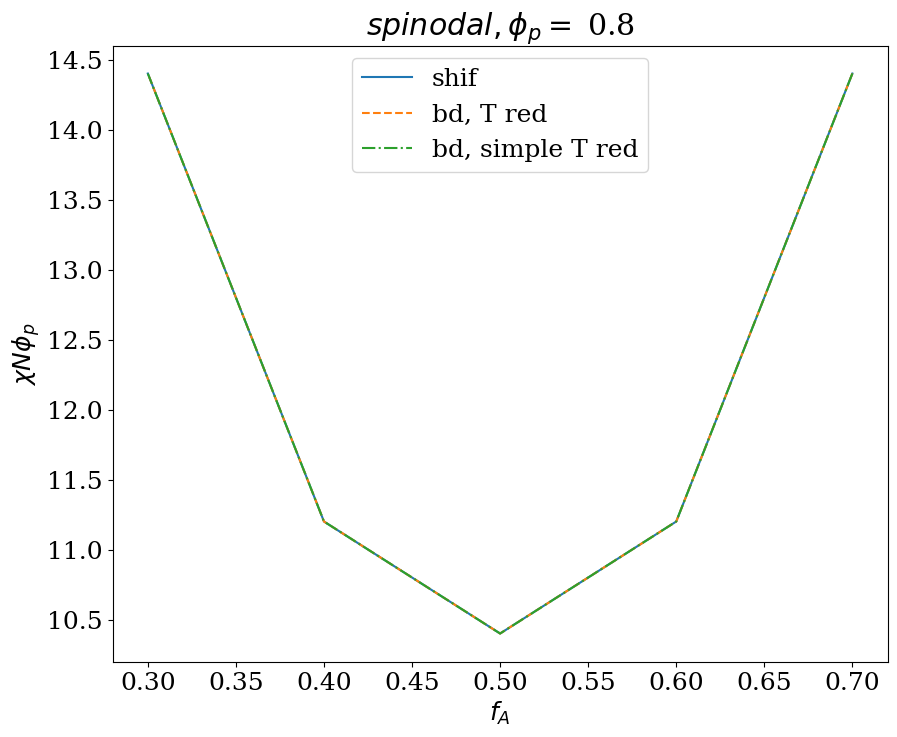

In [64]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
# plt.plot(FA_array, chi_star_arr*N*phi_p, label = r"shif")
# plt.plot(FA_array, chi_star_arr_bd*N*phi_p, label = r"bd, T red", linestyle = "--")
plt.plot(FA_array, chi_star_arr_bd_simple_T*N*phi_p, label = r"bd, simple T red", linestyle = "-.")


# plt.scatter(FA_array, phi_p_chi_star*N*phi_p_arr[i])
plt.legend()
plt.title("$spinodal, \phi_p = $ %s" % phi_p)
plt.xlabel("$f_A$")
plt.ylabel("$\chi N \phi_p$")

### multi phi_p

In [97]:
# %%time
# k* stability analysis; multi phi_p
# phi_p_arr = np.arange(.1,1.01,.1)
phi_p_arr = np.arange(.5,1.01,.1)

chi_star_phi_p_arr = np.zeros((len(phi_p_arr), len(FA_array)))
for p, phi_p_val in enumerate(phi_p_arr):
    A = 1
    v_s = A*b
    vol_terms = [phi_p_val, A, v_s]

    chi_array = np.arange(0, 31, .1)/(N*phi_p)
    
    FA_array = [0.7, 0.6, 0.5, 0.4, 0.3]
    
    min_eigval_arr = np.zeros((len(FA_array), len(chi_array), len(k_vec)))
    
    min_eigval_arr_allk_DENS = np.zeros((len(FA_array), len(chi_array)))
    min_eigval_arr_allk_ps = np.zeros((len(FA_array), len(chi_array)))
    
    min_eigvec_arr = np.zeros((len(FA_array), len(chi_array), len(k_vec), 2))
    min_eigvec_arr_allk_DENS = np.zeros((len(FA_array), len(chi_array), 2))
    
    k_star_arr_DENS= np.zeros((len(FA_array), len(chi_array))) 
    
    for i, FA in enumerate(FA_array):
            
        bind_A = np.zeros(M)
        bind_A[0:int(M*FA)] = 1
        bind_B = 1-bind_A
        
        s_bnd_A = bind_A
        s_bnd_B = bind_B
            # print("mu: ", mu)
        for j, CHI in enumerate(chi_array):
            for ik, k in enumerate(k_vec):
                G2_shifan = abs.gamma2_shifan(chrom, s_bnd_A, s_bnd_B, k, CHI, vol_terms)
                val, vec = np.linalg.eigh(G2_shifan)        
                vec = vec.T
                min_val = np.min(val)            
                min_eigval_arr[i][j][ik] = min_val
                min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]
        
        
            # all-k analysis
            # min eigvals, eigvecs at given mu1,mu2 for each k        
            min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] 
            min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
        
            # minimum eigenvalue at given mu1,mu2 across all ks
            minval_allk = np.min(min_vals) 
            
            # store this eigenvalue and corresponding eigenvector
            min_eigval_arr_allk_DENS[i][j] = minval_allk 
            min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]
        
            k_star = k_vec[np.where(min_vals==minval_allk)]
            k_star_arr_DENS[i][j] = k_star
    
    # setting all non-decomposed/ separated systems to 0 
    psi_1_fluc = min_eigvec_arr_allk_DENS[:,:,0]
    psi_1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0
    
    psi_2_fluc = min_eigvec_arr_allk_DENS[:,:,1]
    psi_2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0
    
    k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal
    
    chi_star_arr = np.zeros(len(FA_array))
    
    for c, fa_kstar_arr in enumerate(k_star_arr_DENS):
        A = fa_kstar_arr
        m1 = A[:-1]<0 
        m2 = np.sign(A[1:]*A[:-1])==-1
        
        r = np.argwhere(np.all(np.vstack([m1,m2]), axis=0))
        ind = np.squeeze(r).tolist()
        chi_star_arr[c] = chi_array[ind]
    chi_star_phi_p_arr[p] = chi_star_arr

In [98]:
phi_p_val

0.9999999999999999

In [87]:
fa_kstar_arr

array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        ,  0.02126112,  0.02126112,  0.02126112,
        0.02126112,  0.02126112,  0.02126112,  0.02126112,  0.02126112,
        0.02126112,  0.02126112,  0.02126112,  0.02126112,  0.02126112,
        0.02126112,  0.02126112,  0.02126112,  0.02126112,  0.02126112,
        0.02126112])

Text(0, 0.5, '$\\chi N \\phi_p$')

<Figure size 640x480 with 0 Axes>

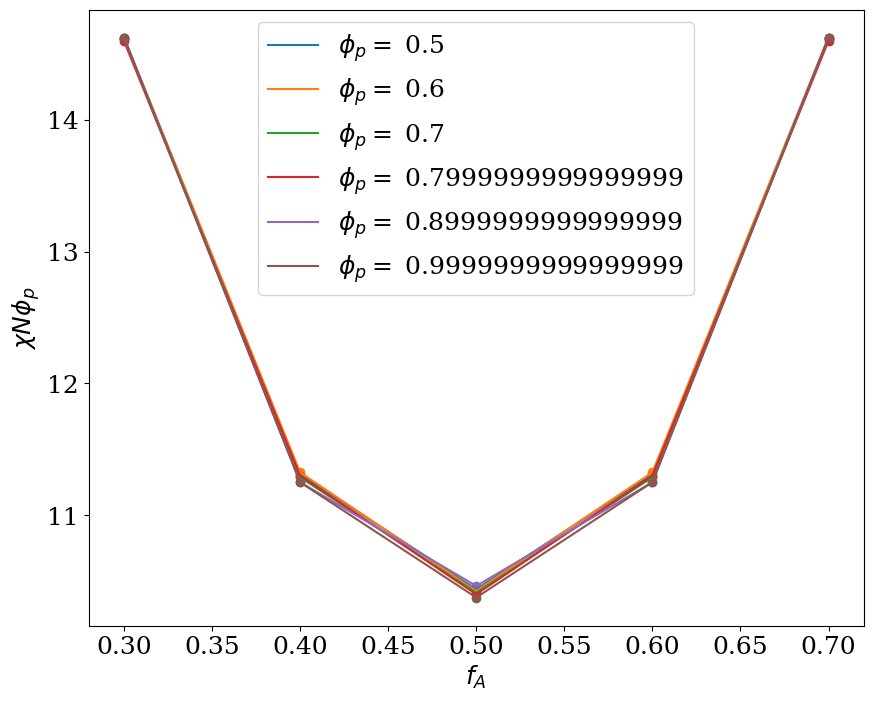

In [106]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
for i,phi_p_chi_star in enumerate(chi_star_phi_p_arr):
    plt.plot(FA_array, phi_p_chi_star*N*phi_p_arr[i], label = r"$\phi_p = $ %s" % phi_p_arr[i])
    plt.scatter(FA_array, phi_p_chi_star*N*phi_p_arr[i])
    plt.legend()
plt.xlabel("$f_A$")
plt.ylabel("$\chi N \phi_p$")

## T mat

In [107]:
# have now confirmed shifans G2 is correct. now must find a T matrix that yields this correct G2_red

In [214]:
phi_p = 0.7
phi_s = 1 - phi_p
A = 1
v_s = A
vol_terms = phi_p, A, v_s
CHI = 100/N

cc_red = abs.eval_and_reduce_cc(M)
s_cgam0_red = abs.eval_and_reduce_cgam(s_bnd_A)
s_cgam1_red = abs.eval_and_reduce_cgam(s_bnd_B)
sisj_AA_red = abs.eval_and_reduce_sisj_bind_simp(chrom, s_bnd_A, s_bnd_A)
sisj_AB_red = abs.eval_and_reduce_sisj_bind_simp(chrom, s_bnd_A, s_bnd_B)
sisj_BA_red = sisj_AB_red
sisj_BB_red = abs.eval_and_reduce_sisj_bind_simp(chrom, s_bnd_B, s_bnd_B)
M2s = [sisj_AA_red,sisj_AB_red,sisj_BA_red,sisj_BB_red, s_cgam0_red, s_cgam1_red, cc_red]

g1g1_shif, g1g2_shif, g2g1_shif, g2g2_shif, cg1_shif, cg2_shif, cc_shif =  (phi_p*N) * (1 / (N**2))* np.array(abs.calc_sf2_chromo_shlk(chrom, M2s, [lam_q]))

ss = (phi_s / v_s ) * v_s**2 

S2_mat_shif =  np.array([[ g1g1_shif[0], g1g2_shif[0], 0],\
                    [g2g1_shif[0], g2g2_shif[0], 0], \
                    [0, 0, ss]])

# unred G2 @ chi = 0
S2_inv_shif = np.linalg.inv(S2_mat_shif)

S2_inv_shif[0,1] += CHI
S2_inv_shif[1,0] += CHI
S2_inv_shif

array([[5.16184170e-04, 1.90965979e-03, 0.00000000e+00],
       [1.90965979e-03, 1.39414317e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.33333333e+00]])

In [215]:
FA = np.sum(s_bnd_A)/len(s_bnd_A)
FB = 1-FA#np.sum(s_bnd_B)/len(s_bnd_B)
T = np.array([[-phi_p, -FA], [phi_p, -FB], [0,v_s**0.5]]) # Shifan solvent effects \Delta_{unred} = T \Delta_{red} 
# T = np.array([[phi_p, 0], [phi_p, -0], [0,0**0.5]]) # Shifan solvent effects \Delta_{unred} = T \Delta_{red} 

print("solvent effects transformation matrix")

G2_red = np.einsum("ij, im, jn -> mn", S2_inv_shif, T, T)
G2_red

solvent effects transformation matrix


array([[-1.55022334e-03,  5.74790402e-04],
       [ 5.74790402e-04,  3.33425016e+00]])

In [216]:
G2_shifan = abs.gamma2_shifan(chrom, s_bnd_A, s_bnd_B, lam_q, CHI, vol_terms)
G2_shifan

array([[-1.55022334e-03,  5.74790402e-04],
       [ 5.74790402e-04,  3.33425016e+00]])

## gamma2

In [27]:
# CHI = 10
CHI = 5/N

FA = 0.3
bind_A = np.zeros(M)
bind_A[0:int(M*FA)] = 1
bind_B = 1-bind_A

s_bnd_A = bind_A
s_bnd_B = bind_B

In [28]:
G2_shifan = abs.gamma2_shifan(chrom, s_bnd_A, s_bnd_B, lam_q, CHI, vol_terms)

In [29]:
G2_shifan

array([[3.40935175e-04, 4.66461118e-05],
       [4.66461118e-05, 5.00010618e+00]])

In [30]:
G2_th = abs.gamma2_alt_T(chrom, s_bnd_A, s_bnd_B, lam_q, CHI, vol_terms)

solvent effects transformation matrix


In [31]:
G2_th

array([[3.40935175e-04, 4.66461118e-05],
       [4.66461118e-05, 5.00010618e+00]])

In [65]:
G2_simpT = abs.gamma2(chrom, s_bnd_A, s_bnd_B, lam_q, CHI, vol_terms)

simple transformation matrix


In [66]:
G2_simpT

array([[5.00044884, 5.00051764],
       [5.00051764, 5.00011914]])

## gamma 3

In [22]:
# q_star = 0.01

cyl_q1 = q_star*np.array([1, 0, 0])
cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])

In [16]:
G3_thomas_alt = abs.gamma3_alt(chrom, s_bnd_A, s_bnd_B, cyl_qs, vol_terms)

In [18]:
G3_thomas_alt

array([[[2499.99942482, 2500.00004516],
        [2500.00004516, 2500.00004516]],

       [[2500.00004516, 2500.00004516],
        [2500.00004516, 2499.99942482]]])

In [42]:
abs.gamma3_alt(chrom, s_bnd_A, s_bnd_B, cyl_qs, [phi_p, 1, 0.001])

array([[[24999999.99942483, 25000000.00004518],
        [25000000.00004518, 25000000.00004518]],

       [[25000000.00004518, 25000000.00004518],
        [25000000.00004518, 24999999.99942483]]])

## gamma4

In [20]:
G4_thomas_alt = abs.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([lam_q, -lam_q, lam_q, -lam_q]), vol_terms)

In [31]:
-G4_thomas_alt

NameError: name 'G4_thomas_alt' is not defined

## phase diag

In [24]:
phi_p = 0.8
A = 1
v_s = A*b # = 1
vol_terms = [phi_p, A, v_s]

In [ ]:
%%time
#SINGLE WAVEMODE PHASE DIAGRAM
N = 50000
# fa_array = [0.6, 0.5, 0.4]#[0.5]#[0.7, 0.6, 0.5, 0.4, 0.3]#[0.3, 0.325, 0.35, 0.375, 0.3875, 0.4, 0.4125, 0.425, 0.4375, 0.45, 0.475, 0.5]#[0.3, 0.35, 0.4, 0.45, 0.5]#np.arange(0.2, 0.51, .02)
# chi_array = np.arange(10, 31, 10)/N#np.arange(5, 30, 0.5)/N #np.array([5, 7, 10, 12, 15, 17, 20])/N #* N

# fa_array = [0.7, 0.6, 0.5, 0.4, 0.3]
# fa_array = [0.3]
# fa_array = [0.3, 0.5, 0.7]

# chi_array = (np.arange(1, 31, 1)/(N*phi_p))

fa_array = [0.3]
chi_array = (np.arange(14.0, 15.0, .001)/(N*phi_p))

bcc_pnts_q = np.array([])
cyl_pnts_q = np.array([])
lam_pnts_q = np.array([])
dis_pnts_q = np.array([])

bcc_pnts_b = np.array([])
cyl_pnts_b = np.array([])
lam_pnts_b = np.array([])
dis_pnts_b = np.array([])

# print("LAM g4 not negative, cyl, bcc G4 negative")
print("all phases")
# print("JUST CYL AND BCC")
for FA in fa_array:
    print("FA: ", FA)
    KS = spinodal(pset, N, FA)
    q_star = KS[0]

    lam_q = q_star*np.array([1, 0, 0])
    
    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
    
    bcc_q1 = 2**(-0.5)*q_star*np.array([1,1,0])
    bcc_q2 = 2**(-0.5)*q_star*np.array([-1,1,0])
    bcc_q3 = 2**(-0.5)*q_star*np.array([0,1,1])
    bcc_q4 = 2**(-0.5)*q_star*np.array([0,1,-1])
    bcc_q5 = 2**(-0.5)*q_star*np.array([1,0,1])
    bcc_q6 = 2**(-0.5)*q_star*np.array([1,0,-1])



    # ################## QUINN ###################    
    bind_A = np.zeros(M)
    bind_A[0:int(M*FA)] = 1
    bind_B = 1-bind_A
    
    s_bnd_A = bind_A
    s_bnd_B = bind_B
    
    lam_g3_q = 0
    G3 = abs.gamma3(chrom, s_bnd_A, s_bnd_B, cyl_qs, vol_terms) # all g3s are eqivlaent
    cyl_g3_q = (1/6)  * (1/(3*np.sqrt(3))) * 12 * G3#
    bcc_g3_q = (4/(3*np.sqrt(6))) * G3
    
    G4_00 = abs.gamma4(chrom, s_bnd_A, s_bnd_B, np.array([lam_q, -lam_q, lam_q, -lam_q]), vol_terms)
    lam_g4_q = (1/24) * (6) * (1) * G4_00#gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))        
    
    cyl_g4_q = (1/24) * (1/9) *(18*G4_00 + \
      72*abs.gamma4(chrom, s_bnd_A, s_bnd_B, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2]), vol_terms) )
    
    bcc_g4_q = (1/24)* (G4_00 \
             + 8*abs.gamma4(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q1, bcc_q3, -bcc_q3]), vol_terms) \
             + 2*abs.gamma4(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q1, bcc_q2, -bcc_q2]), vol_terms) \
             + 4*abs.gamma4(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4]), vol_terms) )
    ################## BINDING ###################    

    bind_A = np.zeros(M)
    bind_A[0:int(M*FA)] = 1
    bind_B = 1-bind_A
    
    s_bnd_A = bind_A
    s_bnd_B = bind_B

    lam_g3_b = 0
    G3 = abs.gamma3_alt(chrom, s_bnd_A, s_bnd_B, cyl_qs, vol_terms) # all g3s are eqivlaent
    cyl_g3_b = (1/6)  * (1/(3*np.sqrt(3))) * 12 * G3#
    bcc_g3_b = (4/(3*np.sqrt(6))) * G3
    
    G4_00 = abs.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([lam_q, -lam_q, lam_q, -lam_q]), vol_terms)
    lam_g4_b = (1/24) * (6) * (1) * G4_00#gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))        
    
    cyl_g4_b = (1/24) * (1/9) *(18*G4_00 + \
      72*abs.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2]), vol_terms) )
    
    bcc_g4_b = (1/24)* (G4_00 \
             + 8*abs.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q1, bcc_q3, -bcc_q3]), vol_terms) \
             + 2*abs.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q1, bcc_q2, -bcc_q2]), vol_terms) \
             + 4*abs.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4]), vol_terms) )
    
    for CHI in chi_array:
        print("CHI N phi_p: ",CHI * N * phi_p) 
        lam_g2_q = (1/2) * 2 * (1) * abs.gamma2(chrom, s_bnd_A, s_bnd_B, q_star, CHI, vol_terms)        
        cyl_g2_q = lam_g2_q
        bcc_g2_q = lam_g2_q

        lam_g2_b = (1/2) * 2 * (1) * abs.gamma2_alt_T(chrom, s_bnd_A, s_bnd_B, q_star, CHI, vol_terms)        
        cyl_g2_b = lam_g2_b
        bcc_g2_b = lam_g2_b

        #############
        
        initial = [0, 0] # A, B
        
        # amps_l = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2_q, amps, amps) \
        #                                    +  np.einsum("ijkl,i,j,k,l ->", -lam_g4_q, amps, amps, amps, amps)), initial, disp=False)
        
        # lamF_q = np.real( np.einsum("ij,i,j ->", lam_g2_q, amps_l, amps_l) \
        #                                 +  np.einsum("ijkl,i,j,k,l ->", -lam_g4_q, amps_l, amps_l, amps_l, amps_l))
        
        res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2_q, amps, amps) \
                                           +  np.einsum("ijkl,i,j,k,l ->", -lam_g4_q, amps, amps, amps, amps)), initial)
        lamF_q = res.fun
        
        # print(lamF)
            
        # amps_l_no4 = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2_q, amps, amps)), initial, disp=False)
        
        # lamF_no4 = np.real(np.einsum("ij,i,j ->", lam_g2_q, amps_l_no4, amps_l_no4))
        
        # amps_cy = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2_q, amps, amps) \
        #                                     + np.einsum("ijk,i,j,k ->", cyl_g3_q, amps, amps, amps) \
        #                                    +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4_q, amps, amps, amps, amps)), initial, disp=False)
        
        # cylF_q = np.real(np.einsum("ij,i,j ->", cyl_g2_q, amps_cy, amps_cy) \
        #                                     + np.einsum("ijk,i,j,k ->", cyl_g3_q, amps_cy, amps_cy, amps_cy) \
        #                                     + np.einsum("ijkl,i,j,k,l ->", -cyl_g4_q, amps_cy, amps_cy, amps_cy, amps_cy))

        res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2_q, amps, amps) \
                                            + np.einsum("ijk,i,j,k ->", cyl_g3_q, amps, amps, amps) \
                                           +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4_q, amps, amps, amps, amps)), initial)
        cylF_q = res.fun
        
        # amps_bcc = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2_q, amps, amps) \
        #                                     + np.einsum("ijk,i,j,k ->", bcc_g3_q, amps, amps, amps) \
        #                                    +  np.einsum("ijkl,i,j,k,l ->", -bcc_g4_q, amps, amps, amps, amps)), initial, disp=False)
        
        # bccF_q = np.real(np.einsum("ij,i,j ->", bcc_g2_q, amps_bcc, amps_bcc) \
        #                                     + np.einsum("ijk,i,j,k ->", bcc_g3_q, amps_bcc, amps_bcc, amps_bcc) \
        #                                     + np.einsum("ijkl,i,j,k,l ->", -bcc_g4_q, amps_bcc, amps_bcc, amps_bcc, amps_bcc))

        res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2_q, amps, amps) \
                                            + np.einsum("ijk,i,j,k ->", bcc_g3_q, amps, amps, amps) \
                                           +  np.einsum("ijkl,i,j,k,l ->", -bcc_g4_q, amps, amps, amps, amps)), initial)
        bccF_q = res.fun
        # ##############
        initial = [0, 0] # A, B
        
        # amps_l = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2_b, amps, amps) \
        #                                    +  np.einsum("ijkl,i,j,k,l ->", -lam_g4_b, amps, amps, amps, amps)), initial, disp=False)
        
        # lamF_b = np.real( np.einsum("ij,i,j ->", lam_g2_b, amps_l, amps_l) \
        #                                 +  np.einsum("ijkl,i,j,k,l ->", -lam_g4_b, amps_l, amps_l, amps_l, amps_l))

        res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2_b, amps, amps) \
                                           +  np.einsum("ijkl,i,j,k,l ->", -lam_g4_b, amps, amps, amps, amps)), initial)

        lamF_b = res.fun
        # print(lamF)
            
        # amps_l_no4 = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2_b, amps, amps)), initial, disp=False)
        
        # lamF_no4 = np.real(np.einsum("ij,i,j ->", lam_g2_b, amps_l_no4, amps_l_no4))
        
        # amps_cy = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2_b, amps, amps) \
        #                                     + np.einsum("ijk,i,j,k ->", cyl_g3_b, amps, amps, amps) \
        #                                    +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4_b, amps, amps, amps, amps)), initial, disp=False)
        
        # cylF_b = np.real(np.einsum("ij,i,j ->", cyl_g2_b, amps_cy, amps_cy) \
        #                                     + np.einsum("ijk,i,j,k ->", cyl_g3_b, amps_cy, amps_cy, amps_cy) \
        #                                     + np.einsum("ijkl,i,j,k,l ->", -cyl_g4_b, amps_cy, amps_cy, amps_cy, amps_cy))
        
        res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2_b, amps, amps) \
                                            + np.einsum("ijk,i,j,k ->", cyl_g3_b, amps, amps, amps) \
                                           +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4_b, amps, amps, amps, amps)), initial)
        cylF_b = res.fun
        
        # amps_bcc = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2_b, amps, amps) \
        #                                     + np.einsum("ijk,i,j,k ->", bcc_g3_b, amps, amps, amps) \
        #                                    +  np.einsum("ijkl,i,j,k,l ->", -bcc_g4_b, amps, amps, amps, amps)), initial, disp=False)
        
        # bccF_b = np.real(np.einsum("ij,i,j ->", bcc_g2_b, amps_bcc, amps_bcc) \
        #                                     + np.einsum("ijk,i,j,k ->", bcc_g3_b, amps_bcc, amps_bcc, amps_bcc) \
        #                                     + np.einsum("ijkl,i,j,k,l ->", -bcc_g4_b, amps_bcc, amps_bcc, amps_bcc, amps_bcc))
        
        res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2_b, amps, amps) \
                                            + np.einsum("ijk,i,j,k ->", bcc_g3_b, amps, amps, amps) \
                                           +  np.einsum("ijkl,i,j,k,l ->", -bcc_g4_b, amps, amps, amps, amps)), initial)    
        bccF_b = res.fun
        
        point = np.array([FA, CHI*N])
        print("Fs: ", [lamF_b, cylF_b, bccF_b])
        # lamF_b = 100000000
        # print("LAM F MADE POSITIVE")
        if (lamF_q >= 0 and cylF_q >= 0 and bccF_q >= 0):
            #disordered stable
            dis_pnts_q = np.append(dis_pnts_q, point)
        elif (lamF_q < cylF_q and lamF_q < bccF_q):
            lam_pnts_q = np.append(lam_pnts_q, point) 
        elif (cylF_q < bccF_q):
            cyl_pnts_q = np.append(cyl_pnts_q, point)
        else:
            bcc_pnts_q = np.append(bcc_pnts_q, point)

        if (lamF_b >= 0 and cylF_b >= 0 and bccF_b >= 0):
            #disordered stable
            dis_pnts_b = np.append(dis_pnts_b, point)
        elif (lamF_b < cylF_b and lamF_b < bccF_b):
            lam_pnts_b = np.append(lam_pnts_b, point) 
        elif (cylF_b < bccF_b):
            cyl_pnts_b = np.append(cyl_pnts_b, point)
        else:
            bcc_pnts_b = np.append(bcc_pnts_b, point)            
    print("one FA done!!")
            

all phases
FA:  0.3
simple transofrmation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
simple transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
CHI N phi_p:  14.0
simple transformation matrix
solvent effects transformation matrix
Fs:  [0.0, 0.0, 0.0]
CHI N phi_p:  14.001
simple transformation matrix
solvent effects transformation matrix
Fs:  [0.0, 0.0, 0.0]
CHI N phi_p:  14.001999999999999
simple transformation matrix
solvent effects transformation matrix
Fs:  [0.0, 0.0, 0.0]
CHI N phi_p:  14.003
simple transformation matrix
solvent effects transformation matrix


In [ ]:
bcc_pnts_b

In [ ]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


ax.scatter(lam_pnts_b[::2], lam_pnts_b[1::2]*phi_p, label = "lam solveff T", color = "lightblue")
ax.scatter(dis_pnts_b[::2], dis_pnts_b[1::2]*phi_p, label = "dis solveff T", color = "grey")
ax.scatter(cyl_pnts_b[::2], cyl_pnts_b[1::2]*phi_p, label = "cyl solveff T", color = "pink")
ax.scatter(bcc_pnts_b[::2], bcc_pnts_b[1::2]*phi_p, label = "bcc solveff T", color = "lightgreen")


ax.scatter(lam_pnts_q[::2], lam_pnts_q[1::2]*phi_p, label = "lam simple T",  color = "blue", marker = "x")
ax.scatter(dis_pnts_q[::2], dis_pnts_q[1::2]*phi_p, label = "dis simple T", color = "black", marker = "x")
ax.scatter(cyl_pnts_q[::2], cyl_pnts_q[1::2]*phi_p, label = "cyl simple T", color = "red", marker = "x")
ax.scatter(bcc_pnts_q[::2], bcc_pnts_q[1::2]*phi_p, label = "bcc simple T",  color = "green", marker = "x")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("N = " + str(N) + " ABS, all phases, all -g4, simple T vs solveff T")
ax.set_ylabel("$\chi N \phi_p$")
ax.set_xlabel("$f_A$")

plt.savefig('quinn_bind_AB_comp.png')

<Figure size 640x480 with 0 Axes>

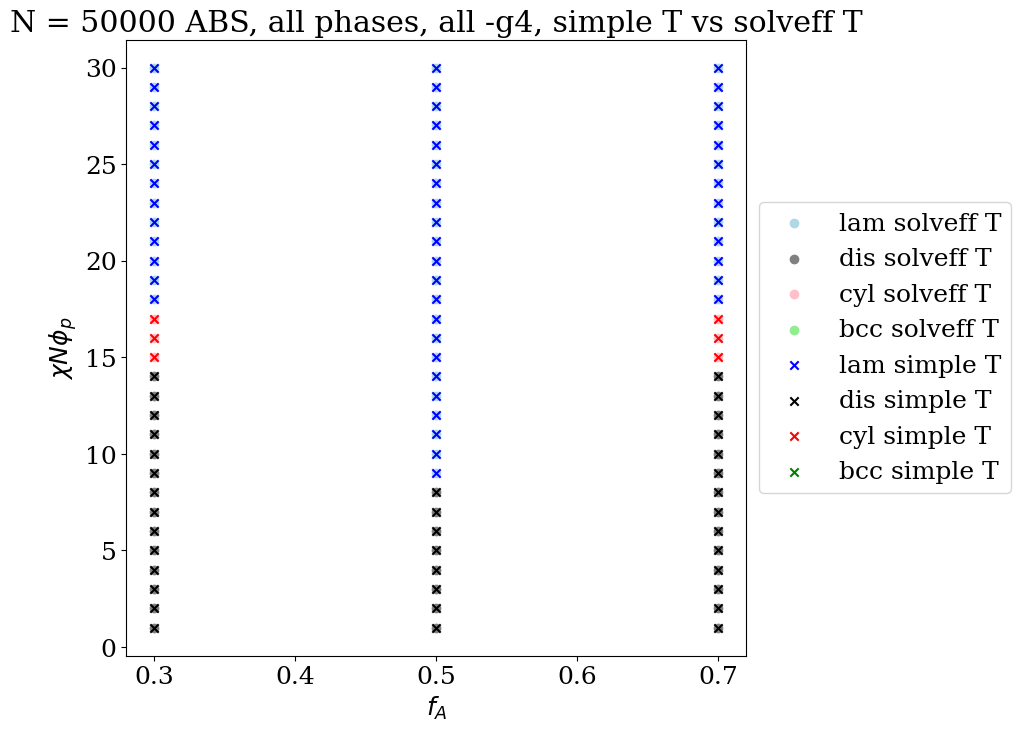

In [136]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


ax.scatter(lam_pnts_b[::2], lam_pnts_b[1::2]*phi_p, label = "lam solveff T", color = "lightblue")
ax.scatter(dis_pnts_b[::2], dis_pnts_b[1::2]*phi_p, label = "dis solveff T", color = "grey")
ax.scatter(cyl_pnts_b[::2], cyl_pnts_b[1::2]*phi_p, label = "cyl solveff T", color = "pink")
ax.scatter(bcc_pnts_b[::2], bcc_pnts_b[1::2]*phi_p, label = "bcc solveff T", color = "lightgreen")


ax.scatter(lam_pnts_q[::2], lam_pnts_q[1::2]*phi_p, label = "lam simple T",  color = "blue", marker = "x")
ax.scatter(dis_pnts_q[::2], dis_pnts_q[1::2]*phi_p, label = "dis simple T", color = "black", marker = "x")
ax.scatter(cyl_pnts_q[::2], cyl_pnts_q[1::2]*phi_p, label = "cyl simple T", color = "red", marker = "x")
ax.scatter(bcc_pnts_q[::2], bcc_pnts_q[1::2]*phi_p, label = "bcc simple T",  color = "green", marker = "x")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("N = " + str(N) + " ABS, all phases, all -g4, simple T vs solveff T")
ax.set_ylabel("$\chi N \phi_p$")
ax.set_xlabel("$f_A$")

plt.savefig('quinn_bind_AB_comp.png')

<Figure size 640x480 with 0 Axes>

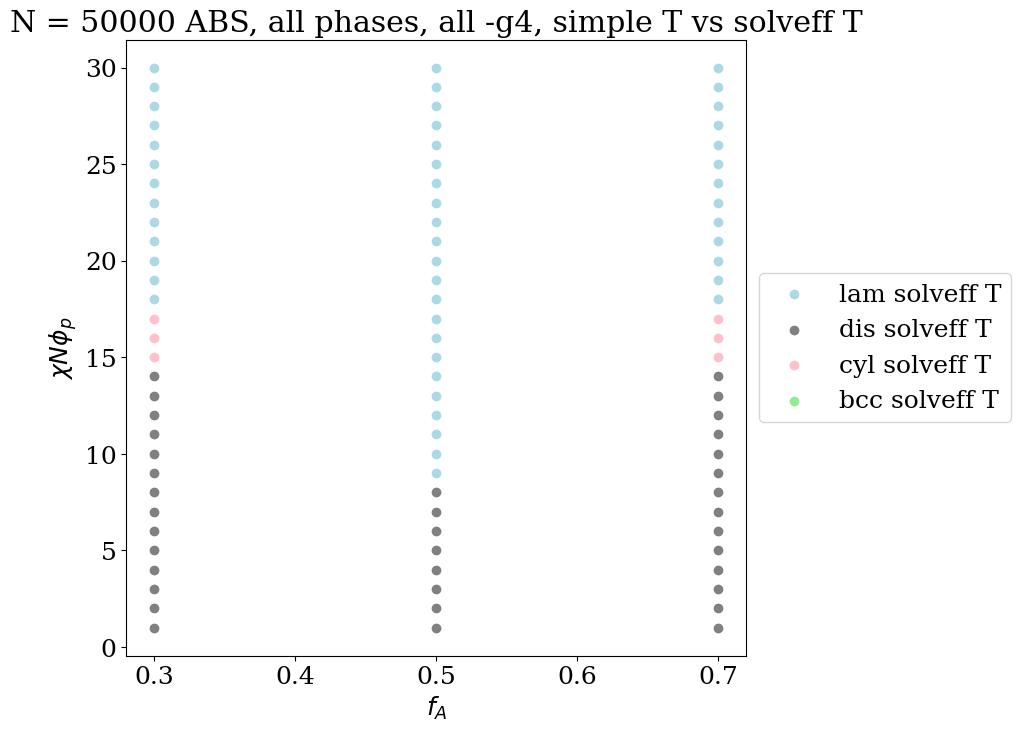

In [138]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


ax.scatter(lam_pnts_b[::2], lam_pnts_b[1::2]*phi_p, label = "lam solveff T", color = "lightblue")
ax.scatter(dis_pnts_b[::2], dis_pnts_b[1::2]*phi_p, label = "dis solveff T", color = "grey")
ax.scatter(cyl_pnts_b[::2], cyl_pnts_b[1::2]*phi_p, label = "cyl solveff T", color = "pink")
ax.scatter(bcc_pnts_b[::2], bcc_pnts_b[1::2]*phi_p, label = "bcc solveff T", color = "lightgreen")


# ax.scatter(lam_pnts_q[::2], lam_pnts_q[1::2]*phi_p, label = "lam simple T",  color = "blue", marker = "x")
# ax.scatter(dis_pnts_q[::2], dis_pnts_q[1::2]*phi_p, label = "dis simple T", color = "black", marker = "x")
# ax.scatter(cyl_pnts_q[::2], cyl_pnts_q[1::2]*phi_p, label = "cyl simple T", color = "red", marker = "x")
# ax.scatter(bcc_pnts_q[::2], bcc_pnts_q[1::2]*phi_p, label = "bcc simple T",  color = "green", marker = "x")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("N = " + str(N) + " ABS, all phases, all -g4, simple T vs solveff T")
ax.set_ylabel("$\chi N \phi_p$")
ax.set_xlabel("$f_A$")

plt.savefig('quinn_bind_AB_comp.png')

<Figure size 640x480 with 0 Axes>

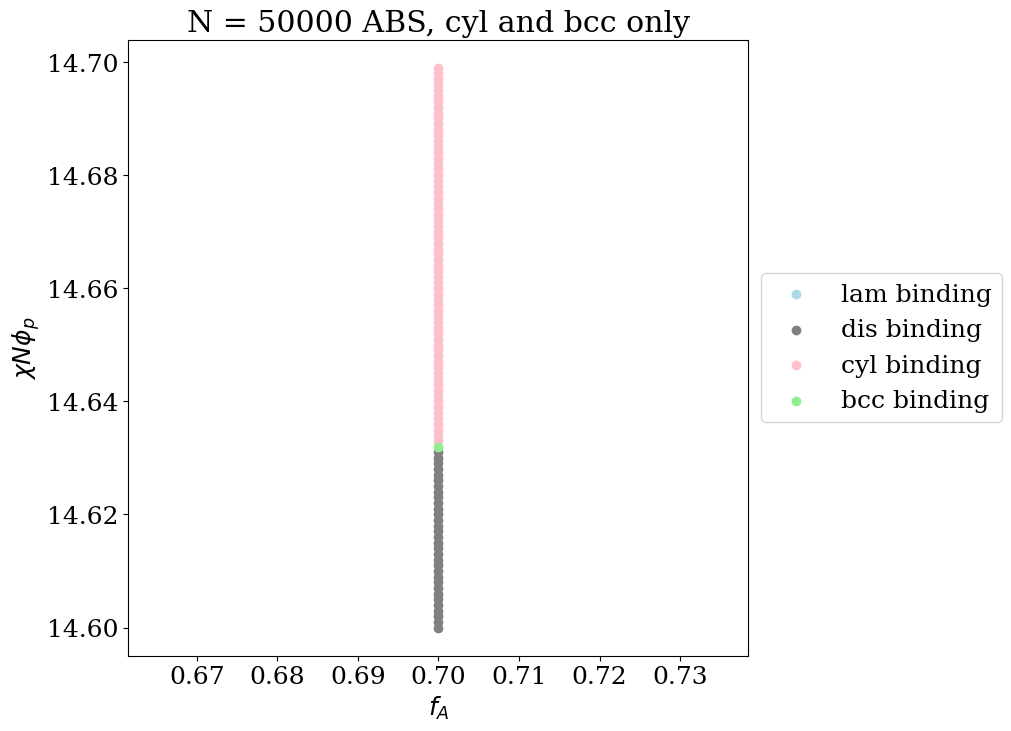

In [83]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


ax.scatter(lam_pnts_b[::2], lam_pnts_b[1::2]*phi_p, label = "lam binding", color = "lightblue")
ax.scatter(dis_pnts_b[::2], dis_pnts_b[1::2]*phi_p, label = "dis binding", color = "grey")
ax.scatter(cyl_pnts_b[::2], cyl_pnts_b[1::2]*phi_p, label = "cyl binding", color = "pink")
ax.scatter(bcc_pnts_b[::2], bcc_pnts_b[1::2]*phi_p, label = "bcc binding", color = "lightgreen")


# ax.scatter(lam_pnts_q[::2], lam_pnts_q[1::2], label = "lam quinn",  color = "blue", marker = "x")
# ax.scatter(dis_pnts_q[::2], dis_pnts_q[1::2], label = "dis quinn", color = "black", marker = "x")
# ax.scatter(cyl_pnts_q[::2], cyl_pnts_q[1::2], label = "cyl quinn", color = "red", marker = "x")
# ax.scatter(bcc_pnts_q[::2], bcc_pnts_q[1::2], label = "bcc quinn",  color = "green", marker = "x")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("N = " + str(N) + " ABS, cyl and bcc only")
ax.set_ylabel("$\chi N \phi_p$")
ax.set_xlabel("$f_A$")

plt.savefig('quinn_bind_AB_comp.png')

In [24]:
amps_l

array([ 3.01117718e+39, -1.00135317e+36])

In [25]:
amps_cy

array([ 4.55014989e-01, -9.34130580e-06])

#### G3 testing

In [99]:
# FA = 0.3

# bind_A = np.zeros(M)
# bind_A[0:int(M*FA)] = 1
# bind_B = 1-bind_A

# s_bnd_A = bind_A
# s_bnd_B = bind_B

# G3 = abs.gamma3(chrom, s_bnd_A, s_bnd_B, cyl_qs, vol_terms) # all g3s are eqivlaent
# G3

simple transofrmation matrix


array([[[24.99794954, 25.00004642],
        [25.00004642, 25.00005986]],

       [[25.00004642, 25.00005986],
        [25.00005986, 24.99971912]]])

In [111]:
FA = 0.3

bind_A = np.zeros(M)
bind_A[0:int(M*FA)] = 1
bind_B = 1-bind_A

s_bnd_A = bind_A
s_bnd_B = bind_B

# lam_g3_b = 0
G3 = abs.gamma3_alt(chrom, s_bnd_A, s_bnd_B, cyl_qs, vol_terms) # all g3s are eqivlaent
cyl_g3_b = (1/6)  * (1/(3*np.sqrt(3))) * 12 * G3#
bcc_g3_b = (4/(3*np.sqrt(6))) * G3

G3_simple = abs.gamma3(chrom, s_bnd_A, s_bnd_B, cyl_qs, vol_terms) # all g3s are eqivlaent

# G4_00 = abs.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([lam_q, -lam_q, lam_q, -lam_q]), vol_terms)
# lam_g4_b = (1/24) * (6) * (1) * G4_00#gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))        

# cyl_g4_b = (1/24) * (1/9) *(18*G4_00 + \
#   72*abs.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2]), vol_terms) )

# bcc_g4_b = (1/24)* (G4_00 \
#          + 8*abs.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q1, bcc_q3, -bcc_q3]), vol_terms) \
#          + 2*abs.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q1, bcc_q2, -bcc_q2]), vol_terms) \
#          + 4*abs.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4]), vol_terms) )

solvent effects transformation matrix
simple transofrmation matrix


In [115]:
.8**3

0.5120000000000001

In [112]:
print("FA: ", FA)
print("G3 shif: ", G3)
print("G3 simp: ", G3_simple)
# print("cylg4: ", cyl_g4_b)
# print("bcc_g4_b: ", bcc_g4_b)

FA:  0.3
G3 shif:  [[[ 8.85385669e-04  5.58690934e-04]
  [ 5.58690934e-04  2.19222874e-05]]

 [[ 5.58690934e-04  2.19222874e-05]
  [ 2.19222874e-05 -2.49998835e+01]]]
G3 simp:  [[[24.99794954 25.00004642]
  [25.00004642 25.00005986]]

 [[25.00004642 25.00005986]
  [25.00005986 24.99971912]]]


In [113]:
FA = 0.7

bind_A = np.zeros(M)
bind_A[0:int(M*FA)] = 1
bind_B = 1-bind_A

s_bnd_A = bind_A
s_bnd_B = bind_B

# lam_g3_b = 0
G3 = abs.gamma3_alt(chrom, s_bnd_A, s_bnd_B, cyl_qs, vol_terms) # all g3s are eqivlaent
cyl_g3_b = (1/6)  * (1/(3*np.sqrt(3))) * 12 * G3#
bcc_g3_b = (4/(3*np.sqrt(6))) * G3

G3_simple = abs.gamma3(chrom, s_bnd_A, s_bnd_B, cyl_qs, vol_terms) # all g3s are eqivlaent

# G4_00 = abs.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([lam_q, -lam_q, lam_q, -lam_q]), vol_terms)
# lam_g4_b = (1/24) * (6) * (1) * G4_00#gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))        

# cyl_g4_b = (1/24) * (1/9) *(18*G4_00 + \
#   72*abs.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2]), vol_terms) )

# bcc_g4_b = (1/24)* (G4_00 \
#          + 8*abs.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q1, bcc_q3, -bcc_q3]), vol_terms) \
#          + 2*abs.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q1, bcc_q2, -bcc_q2]), vol_terms) \
#          + 4*abs.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4]), vol_terms) )

solvent effects transformation matrix
simple transofrmation matrix


In [114]:
print("FA: ", FA)
print("G3 shif: ", G3)
print("G3 simp: ", G3_simple)
# print("cylg4: ", cyl_g4_b)
# print("bcc_g4_b: ", bcc_g4_b)

FA:  0.7
G3 shif:  [[[-8.85385669e-04  5.58690934e-04]
  [ 5.58690934e-04 -2.19222874e-05]]

 [[ 5.58690934e-04 -2.19222874e-05]
  [-2.19222874e-05 -2.49998835e+01]]]
G3 simp:  [[[24.99971912 25.00005986]
  [25.00005986 25.00004642]]

 [[25.00005986 25.00004642]
  [25.00004642 24.99794954]]]


In [107]:
FA = 0.7
bind_A = np.zeros(M)
bind_A[0:int(M*FA)] = 1
bind_B = 1-bind_A

s_bnd_A = bind_A
s_bnd_B = bind_B

K1, K2, K3 = cyl_qs
M3 = abs.calc_mon_mat_3(s_bnd_A, s_bnd_B)

s3 = (phi_p / (N * A))* abs.calc_sf3(chrom, M3, [K1], [K2])[1:4,1:4,1:4]
print(FA)
s3

0.7


array([[[2.02500952e+08, 3.29237295e+07, 0.00000000e+00],
        [3.29237295e+07, 1.94831185e+07, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[3.29237295e+07, 1.94831185e+07, 0.00000000e+00],
        [1.94831185e+07, 3.05439907e+07, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.70099667e+07]]])

In [108]:
FA = 0.3
bind_A = np.zeros(M)
bind_A[0:int(M*FA)] = 1
bind_B = 1-bind_A

s_bnd_A = bind_A
s_bnd_B = bind_B

K1, K2, K3 = cyl_qs
M3 = abs.calc_mon_mat_3(s_bnd_A, s_bnd_B)

s3 = (phi_p / (N * A))* abs.calc_sf3(chrom, M3, [K1], [K2])[1:4,1:4,1:4]
print(FA)
s3

0.3


array([[[3.05439907e+07, 1.94831185e+07, 0.00000000e+00],
        [1.94831185e+07, 3.29237295e+07, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[1.94831185e+07, 3.29237295e+07, 0.00000000e+00],
        [3.29237295e+07, 2.02500952e+08, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.70099667e+07]]])

In [103]:
print("FA: ", FA)
print("G3: ", G3)
print("cylg4: ", cyl_g4_b)
print("bcc_g4_b: ", bcc_g4_b)

FA:  0.7
G3:  [[[-8.85385669e-04  5.58690934e-04]
  [ 5.58690934e-04 -2.19222874e-05]]

 [[ 5.58690934e-04 -2.19222874e-05]
  [-2.19222874e-05 -2.49998835e+01]]]
cylg4:  [[[[-2.08745745e-03+0.j  9.92179231e-04+0.j]
   [ 9.92179231e-04+0.j -6.14315567e-04+0.j]]

  [[ 9.92179231e-04+0.j -5.65012090e-04+0.j]
   [-5.46003885e-04+0.j  1.81713032e-05+0.j]]]


 [[[ 9.92179231e-04+0.j -5.46003885e-04+0.j]
   [-5.65012090e-04+0.j  1.81713032e-05+0.j]]

  [[-6.14315567e-04+0.j  1.81713032e-05+0.j]
   [ 1.81713032e-05+0.j -1.04166795e+02+0.j]]]]
bcc_g4_b:  [[[[-3.92030782e-03+0.j  1.50111879e-03+0.j]
   [ 1.50111879e-03+0.j -8.90237467e-04+0.j]]

  [[ 1.50111879e-03+0.j -1.05346320e-03+0.j]
   [-7.47728061e-04+0.j  3.04457612e-05+0.j]]]


 [[[ 1.50111879e-03+0.j -7.47728061e-04+0.j]
   [-1.05346320e-03+0.j  3.04457612e-05+0.j]]

  [[-8.90237467e-04+0.j  3.04457612e-05+0.j]
   [ 3.04457612e-05+0.j -1.56250207e+02+0.j]]]]


#### Just cylindrical

In [ ]:
vol_terms

In [119]:
N = 50000
# fa_array = [0.6, 0.5, 0.4]#[0.5]#[0.7, 0.6, 0.5, 0.4, 0.3]#[0.3, 0.325, 0.35, 0.375, 0.3875, 0.4, 0.4125, 0.425, 0.4375, 0.45, 0.475, 0.5]#[0.3, 0.35, 0.4, 0.45, 0.5]#np.arange(0.2, 0.51, .02)
# chi_array = np.arange(10, 31, 10)/N#np.arange(5, 30, 0.5)/N #np.array([5, 7, 10, 12, 15, 17, 20])/N #* N

# fa_array = [0.5]
# chi_array = [20/N]

# FA = 0.52
FA = 0.3
CHI = 0.0004
print("CHI N: ",CHI * N) 


KS = spinodal(pset, N, FA)
q_star = KS[0]

lam_q = q_star*np.array([1, 0, 0])

cyl_q1 = q_star*np.array([1, 0, 0])
cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])

bind_A = np.zeros(M)
bind_A[0:int(M*FA)] = 1
bind_B = 1-bind_A

s_bnd_A = bind_A
s_bnd_B = bind_B
G3 = abs.gamma3_alt(chrom, s_bnd_A, s_bnd_B, cyl_qs, vol_terms) # all g3s are eqivlaent
cyl_g3_b = (1/6)  * (1/(3*np.sqrt(3))) * 12 * G3#
G4_00 = abs.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([lam_q, -lam_q, lam_q, -lam_q]), vol_terms)
cyl_g4_b = (1/24) * (1/9) *(18*G4_00 + \
  72*abs.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2]), vol_terms) )

lam_g2_b = (1/2) * 2 * (1) * abs.gamma2_alt_T(chrom, s_bnd_A, s_bnd_B, q_star, CHI, vol_terms)        
cyl_g2_b = lam_g2_b




CHI N:  20.0
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix
solvent effects transformation matrix


In [118]:
initial = [0, 0] # A, B
amps_cy = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2_b, amps, amps) \
                                    + np.einsum("ijk,i,j,k ->", cyl_g3_b, amps, amps, amps) \
                                   +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4_b, amps, amps, amps, amps)), initial, disp=False)

cylF_b = np.real(np.einsum("ij,i,j ->", cyl_g2_b, amps_cy, amps_cy) \
                                    + np.einsum("ijk,i,j,k ->", cyl_g3_b, amps_cy, amps_cy, amps_cy) \
                                    + np.einsum("ijkl,i,j,k,l ->", -cyl_g4_b, amps_cy, amps_cy, amps_cy, amps_cy))
print(cylF_b)
print(FA)
print(CHI*N*phi_p)
print(amps_cy)

-1.2116630297854518e-06
0.7
16.0
[1.80464853e-01 5.34001067e-06]


In [120]:
initial = [0, 0] # A, B
amps_cy = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2_b, amps, amps) \
                                    + np.einsum("ijk,i,j,k ->", cyl_g3_b, amps, amps, amps) \
                                   +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4_b, amps, amps, amps, amps)), initial, disp=False)

# amps_cy = [-1.80464853e-01, 5.34001067e-06]  # 0.7 amp, with A amp made negative
cylF_b = np.real(np.einsum("ij,i,j ->", cyl_g2_b, amps_cy, amps_cy) \
                                    + np.einsum("ijk,i,j,k ->", cyl_g3_b, amps_cy, amps_cy, amps_cy) \
                                    + np.einsum("ijkl,i,j,k,l ->", -cyl_g4_b, amps_cy, amps_cy, amps_cy, amps_cy))
print(cylF_b)
print(FA)
print(CHI*N*phi_p)
print(amps_cy)

-5.685705353223978e-08
0.3
16.0
[ 5.79314054e-02 -1.80648045e-06]


In [123]:
import scipy as sp

In [130]:
initial = [0, 0] # A, B
# initial =  [-1.80464853e-01, 5.34001067e-06] 

res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2_b, amps, amps) \
                                    + np.einsum("ijk,i,j,k ->", cyl_g3_b, amps, amps, amps) \
                                   +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4_b, amps, amps, amps, amps)), initial)

In [133]:
FA

0.3

In [131]:
res.x

array([-1.80438198e-01,  5.38348592e-06])

In [132]:
res.fun

-1.2116631702600143e-06

In [122]:
# initial = [0, 0] # A, B
initial =  [-1.80464853e-01, 5.34001067e-06] 
amps_cy = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2_b, amps, amps) \
                                    + np.einsum("ijk,i,j,k ->", cyl_g3_b, amps, amps, amps) \
                                   +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4_b, amps, amps, amps, amps)), initial, disp=False)

# amps_cy = [-1.80464853e-01, 5.34001067e-06]  # 0.7 amp, with A amp made negative
cylF_b = np.real(np.einsum("ij,i,j ->", cyl_g2_b, amps_cy, amps_cy) \
                                    + np.einsum("ijk,i,j,k ->", cyl_g3_b, amps_cy, amps_cy, amps_cy) \
                                    + np.einsum("ijkl,i,j,k,l ->", -cyl_g4_b, amps_cy, amps_cy, amps_cy, amps_cy))
print(cylF_b)
print(FA)
print(CHI*N*phi_p)
print(amps_cy)

-1.2116630297821377e-06
0.3
16.0
[-1.80464853e-01  5.34001067e-06]


In [64]:
initial = [0, 0] # A, B
amps_cy = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2_b, amps, amps) \
                                    + np.einsum("ijk,i,j,k ->", cyl_g3_b, amps, amps, amps) \
                                   +  np.einsum("ijkl,i,j,k,l ->", cyl_g4_b, amps, amps, amps, amps)), initial, disp=False)

cylF_b = np.real(np.einsum("ij,i,j ->", cyl_g2_b, amps_cy, amps_cy) \
                                    + np.einsum("ijk,i,j,k ->", cyl_g3_b, amps_cy, amps_cy, amps_cy) \
                                    + np.einsum("ijkl,i,j,k,l ->", cyl_g4_b, amps_cy, amps_cy, amps_cy, amps_cy))
print(cylF_b)
print(FA)
print(CHI*N*phi_p)

-2.1203962122671408e+154
0.7
16.0


In [60]:
initial = [0, 0] # A, B
amps_cy = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2_b, amps, amps) \
                                    + np.einsum("ijk,i,j,k ->", cyl_g3_b, amps, amps, amps) \
                                   +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4_b, amps, amps, amps, amps)), initial, disp=False)

cylF_b = np.real(np.einsum("ij,i,j ->", cyl_g2_b, amps_cy, amps_cy) \
                                    + np.einsum("ijk,i,j,k ->", cyl_g3_b, amps_cy, amps_cy, amps_cy) \
                                    + np.einsum("ijkl,i,j,k,l ->", -cyl_g4_b, amps_cy, amps_cy, amps_cy, amps_cy))
print(cylF_b)
print(FA)
print(CHI*N*phi_p)

-1.823316341749877e-05
0.5
16.0


In [61]:
initial = [0, 0] # A, B
amps_cy = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2_b, amps, amps) \
                                    + np.einsum("ijk,i,j,k ->", cyl_g3_b, amps, amps, amps) \
                                   +  np.einsum("ijkl,i,j,k,l ->", cyl_g4_b, amps, amps, amps, amps)), initial, disp=False)

cylF_b = np.real(np.einsum("ij,i,j ->", cyl_g2_b, amps_cy, amps_cy) \
                                    + np.einsum("ijk,i,j,k ->", cyl_g3_b, amps_cy, amps_cy, amps_cy) \
                                    + np.einsum("ijkl,i,j,k,l ->", cyl_g4_b, amps_cy, amps_cy, amps_cy, amps_cy))
print(cylF_b)
print(FA)
print(CHI*N*phi_p)

-3.4983936139097625e+154
0.5
16.0


#### Just lamellar

In [7]:
vol_terms

[0.8, 1, 1]

In [41]:
26/M

0.52

In [56]:
N = 50000
# fa_array = [0.6, 0.5, 0.4]#[0.5]#[0.7, 0.6, 0.5, 0.4, 0.3]#[0.3, 0.325, 0.35, 0.375, 0.3875, 0.4, 0.4125, 0.425, 0.4375, 0.45, 0.475, 0.5]#[0.3, 0.35, 0.4, 0.45, 0.5]#np.arange(0.2, 0.51, .02)
# chi_array = np.arange(10, 31, 10)/N#np.arange(5, 30, 0.5)/N #np.array([5, 7, 10, 12, 15, 17, 20])/N #* N

# fa_array = [0.5]
# chi_array = [20/N]

# FA = 0.52
FA = 0.5
CHI = 0.0004
print("CHI N: ",CHI * N) 

KS = spinodal(pset, N, FA)
q_star = KS[0]

lam_q = q_star*np.array([1, 0, 0])

bind_A = np.zeros(M)
bind_A[0:int(M*FA)] = 1
bind_B = 1-bind_A

s_bnd_A = bind_A
s_bnd_B = bind_B

G4_00 = abs.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([lam_q, -lam_q, lam_q, -lam_q]), vol_terms)
lam_g4_b_shif = (1/24) * (6) * (1) * G4_00#gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))        

G4_00 = abs.gamma4(chrom, s_bnd_A, s_bnd_B, np.array([lam_q, -lam_q, lam_q, -lam_q]), vol_terms)
lam_g4_b_simp = (1/24) * (6) * (1) * G4_00#gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))        

lam_g2_b_shif = (1/2) * 2 * (1) * abs.gamma2_alt_T(chrom, s_bnd_A, s_bnd_B, q_star, CHI, vol_terms)        
lam_g2_b_simp = (1/2) * 2 * (1) * abs.gamma2(chrom, s_bnd_A, s_bnd_B, q_star, CHI, vol_terms)        



CHI N:  20.0
solvent effects transformation matrix
simple transformation matrix
solvent effects transformation matrix
simple transformation matrix


In [45]:
initial = [0, 0] # psi1, psi2

amps_l = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2_b_shif, amps, amps) \
                                   +  np.einsum("ijkl,i,j,k,l ->", lam_g4_b_shif, amps, amps, amps, amps)), initial, disp=False)

lamF_b_shif = np.real( np.einsum("ij,i,j ->", lam_g2_b_shif, amps_l, amps_l) \
                                +  np.einsum("ijkl,i,j,k,l ->", lam_g4_b_shif, amps_l, amps_l, amps_l, amps_l))

print(lamF_b_shif)
print(FA)
print(CHI*N*phi_p)

-0.00010004018827146023
0.52
16.0


In [55]:
initial = [0, 0] # psi1, psi2

amps_l = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2_b_shif, amps, amps) \
                                   +  np.einsum("ijkl,i,j,k,l ->", lam_g4_b_shif, amps, amps, amps, amps)), initial, disp=False)

lamF_b_shif = np.real( np.einsum("ij,i,j ->", lam_g2_b_shif, amps_l, amps_l) \
                                +  np.einsum("ijkl,i,j,k,l ->", lam_g4_b_shif, amps_l, amps_l, amps_l, amps_l))

print(lamF_b_shif)
print(FA)
print(CHI*N*phi_p)

-6.370460776551108e+153
0.7
16.0


In [58]:
initial = [0, 0] # psi1, psi2

amps_l = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2_b_shif, amps, amps) \
                                   +  np.einsum("ijkl,i,j,k,l ->", -lam_g4_b_shif, amps, amps, amps, amps)), initial, disp=False)

lamF_b_shif = np.real( np.einsum("ij,i,j ->", lam_g2_b_shif, amps_l, amps_l) \
                                +  np.einsum("ijkl,i,j,k,l ->", -lam_g4_b_shif, amps_l, amps_l, amps_l, amps_l))

print(lamF_b_shif)
print(FA)
print(CHI*N*phi_p)

-6.553848744292749e+153
0.5
16.0


In [33]:
# initial = [0, 0] # psi1, psi2

# amps_l = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2_b_simp, amps, amps) \
#                                    +  np.einsum("ijkl,i,j,k,l ->", lam_g4_b_simp, amps, amps, amps, amps)), initial, disp=False)

# lamF_b_simp = np.real( np.einsum("ij,i,j ->", lam_g2_b_simp, amps_l, amps_l) \
#                                 +  np.einsum("ijkl,i,j,k,l ->", lam_g4_b_simp, amps_l, amps_l, amps_l, amps_l))

# print(lamF_b_simp)

In [46]:
lamF_b

-2.281122467079224e+158

In [47]:
amps_l

array([ 4.12513456e+40, -4.36723202e+38])

In [49]:
lam_g2_b

array([[-0.12753106,  0.03201465],
       [ 0.03201465,  5.04206418]])

In [21]:
lam_g4_b

array([[[[ 7.97171958e-05+0.j, -2.43945489e-19+0.j],
         [ 5.14996032e-19+0.j, -4.18636821e-04+0.j]],

        [[-6.23416249e-19+0.j, -3.20818984e-04+0.j],
         [ 4.51143074e-05+0.j, -6.77626358e-21+0.j]]],


       [[[-9.21571847e-19+0.j,  4.51143074e-05+0.j],
         [-3.20818984e-04+0.j,  4.74338450e-20+0.j]],

        [[-4.18636821e-04+0.j,  6.09863722e-20+0.j],
         [ 1.01643954e-19+0.j, -6.25000628e+01+0.j]]]])

In [22]:
-cyl_g4_b

array([[[[ 4.25523105e-04-0.j, -6.05346213e-19-0.j],
         [-3.88505778e-19-0.j,  4.39984397e-04-0.j]],

        [[-7.31836466e-19-0.j,  4.06621281e-04-0.j],
         [ 4.01788103e-04-0.j,  3.83988269e-20-0.j]]],


       [[[-7.77011557e-19-0.j,  4.01788103e-04-0.j],
         [ 4.06621281e-04-0.j,  3.83988269e-20-0.j]],

        [[ 4.39984397e-04-0.j, -2.25875453e-21-0.j],
         [ 2.03287907e-20-0.j,  1.04166789e+02-0.j]]]])

In [23]:
-bcc_g4_b

array([[[[ 1.06379746e-03-0.j, -4.65755183e-18-0.j],
         [-4.63948180e-18-0.j,  6.39355955e-04-0.j]],

        [[-3.49203450e-18-0.j,  7.61577453e-04-0.j],
         [ 5.39612807e-04-0.j,  1.90864757e-19-0.j]]],


       [[[-3.83988269e-18-0.j,  5.39612807e-04-0.j],
         [ 7.61577453e-04-0.j,  2.99284975e-19-0.j]],

        [[ 6.39355955e-04-0.j,  4.40457133e-20-0.j],
         [ 4.63044678e-20-0.j,  1.56250196e+02-0.j]]]])

In [20]:
print("lam, cyl, bcc Fs: ", [lamF_b, cylF_b, bccF_b])

lam, cyl, bcc Fs:  [-9.732456014745632e-05, -3.4983936139097625e+154, -8.745897203935993e+154]


In [22]:
initial = [0, 0] # A, B

optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2_b, amps, amps) \
                                           +  np.einsum("ijkl,i,j,k,l ->", -lam_g4_b, amps, amps, amps, amps)), initial, disp=False)

array([ 3.04775298e+37, -3.12957807e+37])

In [24]:
amps = [0,0]
np.real(np.einsum("ij,i,j ->", lam_g2_b, amps, amps) \
                                           +  np.einsum("ijkl,i,j,k,l ->", -lam_g4_b, amps, amps, amps, amps))

0.0

# AB/ leibler comparison:

In [3]:
# import PABS_vertex_calc as PABS
import AB_vertex_calc as bd

In [4]:
ID = 23457.04

# looping = "full mark dens comp alt f_bind,"

settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\binder_diblock\ID=%s_settings.npy" % (ID), allow_pickle = True)

[chrom, [klog_min, klog_max, klog_num]] = settings

# [n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
[n_bind, v_int, Vol_int, e_m, rho_p, rho_s, poly_marks, M, mu_max, mu_min, del_mu, alpha, N, N_m, b] = chrom

[pa_vec, marks_2] = poly_marks

mu1_array = np.arange(mu_min, mu_max, del_mu)
mu2_array = np.arange(mu_min, mu_max, del_mu)

k_vec = np.logspace(klog_min, klog_max, klog_num) / b
  
# s2_mats = np.load(r"C:\Users\tmhab\wlcsim_membrane\binder_diblock\ID=%s_chrom_s2_mats_v_int=[[%s,%s],[%s,%s]],diblock,mu_max=%s.npy"\
#                  % (ID, v_int[0,0], v_int[0,1], v_int[1,0], v_int[1,1], mu_max), allow_pickle = True)

s_bind_A_arr = np.load(r"ID=%s_s_bind_A.npy" % ID, allow_pickle=True)
s_bind_B_arr = np.load(r"ID=%s_s_bind_B.npy" % ID, allow_pickle=True)
spacing = int(1 / del_mu)


print("rho_p (# / nm^3): ", rho_p)
print("rho_s (# / nm^3): ", alpha * rho_p/ M)
print("M: ", M)
print("N: ", N)
print("b: ", b)

print("mu1 array:", mu1_array)
print("v_int: ", v_int)

print("k_vec array:", k_vec)


rho_p (# / nm^3):  3.0100000000000006e-09
rho_s (# / nm^3):  63.99999980736
M:  50
N:  50000
b:  1
mu1 array: [-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5]
v_int:  [[-4  4]
 [ 4 -4]]
k_vec array: [0.00316228 0.00356225 0.00401281 0.00452035 0.0050921  0.00573615
 0.00646167 0.00727895 0.00819961 0.00923671 0.01040498 0.01172102
 0.01320352 0.01487352 0.01675475 0.01887392 0.02126112 0.02395027
 0.02697954 0.03039195 0.03423598 0.0385662  0.04344412 0.04893901
 0.0551289  0.06210169 0.06995642 0.07880463 0.08877197 0.1       ]


In [5]:
N

50000

In [6]:
# M = 100
# chrom[7] = M
# chrom[-2] = N / M

In [7]:
bind_A = np.zeros(M)
bind_A[0:len(bind_A)//5] = 1
bind_B = 1-bind_A

s_bnd_A = bind_A
s_bnd_B = bind_B

FA = 0.2

KS = spinodal(pset, N, FA)
q_star = KS[0]

lam_q = q_star*np.array([1, 0, 0])
Ks = np.array([lam_q, -lam_q, lam_q, -lam_q])

In [9]:
len(bind_A)

50

In [10]:
# np.arange(4*4*4).reshape((4,4,4))

In [13]:
# s3_old = np.arange(4*4*4).reshape((4,4,4))
# s3_old[1:3,1:3,1:3]

# gamma3

In [17]:
q_star = 0.01

cyl_q1 = q_star*np.array([1, 0, 0])
cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])

In [18]:
G3_quinn = gamma3(pset, N, FA, cyl_qs)

C:\Users\tmhab\wlcsim_membrane\binder_diblock\./Vertex/subroutines\MultiPoint.py:206: RuntimeWarning: invalid value encountered in scalar divide
  if abs(out/(sum2+tol))<tol and l2>max(lam0_2,lam_2):
C:\Users\tmhab\wlcsim_membrane\binder_diblock\./Vertex/subroutines\MultiPoint.py:209: RuntimeWarning: invalid value encountered in scalar divide
  if abs(sum2/(sum1+tol))<tol and l1>max(lam0_1,lam_1):


In [70]:
G3_thomas = bd.gamma3(chrom, s_bnd_A, s_bnd_B, cyl_qs)

In [19]:
G3_thomas_alt = bd.gamma3_alt(chrom, s_bnd_A, s_bnd_B, cyl_qs)

s3:  [[[2.54833076e+08 1.94537714e+08]
  [1.94537714e+08 1.94537714e+08]]

 [[1.94537714e+08 1.94537714e+08]
  [1.94537714e+08 2.54833076e+08]]]
s2_inv_1:  [[ 0.00022045 -0.00016862]
 [-0.00016862  0.00022045]]
s2_inv_2:  [[ 0.00022045 -0.00016862]
 [-0.00016862  0.00022045]]
s2_inv_3:  [[ 0.00022045 -0.00016862]
 [-0.00016862  0.00022045]]


In [72]:
G3_thomas*N**2

-1.5146129380243427e-18

In [20]:
G3_quinn

0j

In [21]:
G3_thomas_alt

4.336808689942018e-19

# gamma4

In [15]:
N

50000

In [14]:
FA

0.5

In [35]:
G4_quinn = gamma4(pset, wigset, N, FA, Ks)

In [36]:
G4_thomas = bd.gamma4(chrom, s_bnd_A, s_bnd_B, np.array([lam_q, -lam_q, lam_q, -lam_q]))

part1: [[[[ 1.25762694e-17 -6.33645334e-18]
   [-6.33645334e-18  1.11078946e-17]]

  [[-6.33645334e-18  1.74000232e-18]
   [ 1.11078946e-17 -6.33645334e-18]]]


 [[[-6.33645334e-18  1.11078946e-17]
   [ 1.74000232e-18 -6.33645334e-18]]

  [[ 1.11078946e-17 -6.33645334e-18]
   [-6.33645334e-18  1.25762694e-17]]]]
part1 times N**3: [[[[ 0.00157203 -0.00079206]
   [-0.00079206  0.00138849]]

  [[-0.00079206  0.0002175 ]
   [ 0.00138849 -0.00079206]]]


 [[[-0.00079206  0.00138849]
   [ 0.0002175  -0.00079206]]

  [[ 0.00138849 -0.00079206]
   [-0.00079206  0.00157203]]]]
part2: [[[[ 2.61839267e-17+0.j -6.45446661e-18+0.j]
   [-6.45446661e-18+0.j  1.76575122e-17+0.j]]

  [[-6.45446661e-18+0.j  2.36122504e-18+0.j]
   [ 2.36122504e-18+0.j -6.45446661e-18+0.j]]]


 [[[-6.45446661e-18+0.j  2.36122504e-18+0.j]
   [ 2.36122504e-18+0.j -6.45446661e-18+0.j]]

  [[ 1.76575122e-17+0.j -6.45446661e-18+0.j]
   [-6.45446661e-18+0.j  2.61839267e-17+0.j]]]]
part2 times N**3: [[[[ 0.00327299+0.j -0.000806

In [9]:
G4_thomas_alt = bd.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([lam_q, -lam_q, lam_q, -lam_q]))

In [16]:
# -G4_thomas*N**3

In [17]:
G4_quinn

(0.003125800574967903-1.3297557266907784e-17j)

In [18]:
-G4_thomas_alt

(0.0031259703108650217-0j)

In [ ]:
# G4_quinn

# gamma 2

In [106]:
CHI = 10

In [107]:
G2_quinn = gamma2(pset, N, FA, [0.3], CHI)

In [108]:
G2_thomas = bd.gamma2(chrom, s_bnd_A, s_bnd_B, lam_q, CHI)

chi divided by N


In [109]:
G2_thomas_alt = bd.gamma2_alt(chrom, s_bnd_A, s_bnd_B, lam_q, CHI)

s2s div by N


In [ ]:
G2_thomas*N

In [ ]:
G2_thomas_alt

In [ ]:
G2_quinn

# lam free E

In [ ]:
amp_l_quinn = optimize.fmin(lambda amps: np.real(amps**2 * G2_quinn + amps**4 * (1/24) * (6) * (1) * G4_quinn), \
                      1, disp=False)

lamF_quinn = amp_l_quinn**2 * G2_quinn + amp_l_quinn**4 *  (1/24) * (6) * (1) *G4_quinn 
lamF_quinn

In [ ]:
amp_l_quinn

In [ ]:
# N factors
amp_l_thomas = optimize.fmin(lambda amps: np.real(amps**2 * G2_thomas*N - amps**4 * (1/24) * (6) * (1) * G4_thomas*N**3), \
                      1, disp=False)

lamF_thomas = amp_l_thomas**2 * G2_thomas*N**1 - amp_l_thomas**4 *  (1/24) * (6) * (1) *G4_thomas *N**3
lamF_thomas

In [ ]:
amp_l_thomas

In [ ]:
# No N factors
amp_l_thomas = optimize.fmin(lambda amps: np.real(amps**2 * G2_thomas - amps**4 * (1/24) * (6) * (1) * G4_thomas), \
                      1, disp=False)

lamF_thomas = amp_l_thomas**2 * G2_thomas - amp_l_thomas**4 *  (1/24) * (6) * (1) *G4_thomas 
lamF_thomas

In [ ]:
amp_l_thomas

In [ ]:
# G2 only
amp_l_thomas = optimize.fmin(lambda amps: np.real(amps**2 * G2_thomas), \
                      1, disp=False)

lamF_thomas = amp_l_thomas**2 * G2_thomas  
lamF_thomas

In [ ]:
G2_thomas = bd.gamma2(chrom, s_bnd_A, s_bnd_B, lam_q, 0)
amp_l_thomas = optimize.fmin(lambda amps: np.real(amps**2 * G2_thomas - amps**4 * (1/24) * (6) * (1) * G4_thomas), \
                      1, disp=False)

lamF_thomas = amp_l_thomas**2 * G2_thomas - amp_l_thomas**4 *  (1/24) * (6) * (1) *G4_thomas 
lamF_thomas

In [ ]:
N

In [ ]:
G4_quinn = gamma4(pset, wigset, N, FA, Ks)
G4_thomas = bd.gamma4(chrom, s_bnd_A, s_bnd_B, np.array([lam_q, -lam_q, lam_q, -lam_q]))


# phase diagram

In [19]:
N

50000

In [20]:
FA

0.5

In [49]:
lam_q[0]

0.021298653979221677

In [57]:
# chi_arr = np.arange(0,20,5)/N
chi_arr = np.array([0, 10, 11, 13, 20]) / N
# chi_arr = np.array([20]) / N

for CHI in chi_arr:
    G2_quinn = gamma2(pset, N, FA, lam_q[0], CHI)
    G2_thomas = bd.gamma2(chrom, s_bnd_A, s_bnd_B, lam_q[0], CHI)

    amp_l_quinn = optimize.fmin(lambda amps: np.real(amps**2 * G2_quinn + amps**4 * (1/24) * (6) * (1) * G4_quinn), \
                          1, disp=False)
    
    lamF_quinn = amp_l_quinn**2 * G2_quinn + amp_l_quinn**4 *  (1/24) * (6) * (1) *G4_quinn 
    # lamF_quinn
    
    # thomas, No N factors
    amp_l_thomas_no_N = optimize.fmin(lambda amps: np.real(amps**2 * G2_thomas - amps**4 * (1/24) * (6) * (1) * G4_thomas), \
                          1, disp=False)
    
    lamF_thomas_no_N = amp_l_thomas_no_N**2 * G2_thomas - amp_l_thomas_no_N**4 *  (1/24) * (6) * (1) *G4_thomas 
    # lamF_thomas
    
    # N factors
    amp_l_thomas = optimize.fmin(lambda amps: np.real(amps**2 * G2_thomas*N - amps**4 * (1/24) * (6) * (1) * G4_thomas*N**3), \
                          1, disp=False)
    
    lamF_thomas = amp_l_thomas**2 * G2_thomas*N**1 - amp_l_thomas**4 *  (1/24) * (6) * (1) *G4_thomas *N**3
    # lamF_thomas
    print("CHI N = ", CHI*N)
    print(" lamF_quinn: ",  lamF_quinn)
    # print(" lamF_thomas_no_N: ",  lamF_thomas_no_N)
    print(" lamF_thomas_with_N: ",  lamF_thomas)


chi divided by N
CHI N =  0.0
 lamF_quinn:  [3.31147312e-34+4.94685389e-50j]
 lamF_thomas_with_N:  [[3.31159838e-34+0.j]]
chi divided by N
CHI N =  10.0
 lamF_quinn:  [1.56029498e-35+4.94685389e-50j]
 lamF_thomas_with_N:  [[1.56154757e-35+0.j]]
chi divided by N
CHI N =  11.0
 lamF_quinn:  [-1.30809746e-07+2.54722626e-22j]
 lamF_thomas_with_N:  [[-1.30597294e-07+0.j]]
chi divided by N
CHI N =  12.999999999999998
 lamF_quinn:  [-3.21333073e-06-9.64754251e-21j]
 lamF_thomas_with_N:  [[-3.2121381e-06+0.j]]
chi divided by N
CHI N =  20.0
 lamF_quinn:  [-4.62498921e-05-1.8154088e-19j]
 lamF_thomas_with_N:  [[-4.62435173e-05+0.j]]


In [40]:
lam_g4

(0.0007814501437419757-3.324389316726946e-18j)

In [26]:
(1/24) * (6) * (1) * G4_quinn

(0.0007814501437419757-3.324389316726946e-18j)

In [53]:
lam_g2

(-0.0003802209112780366+6.270882299335896e-20j)

In [55]:
G2_quinn

(-0.0003802209112780366+6.270882299335896e-20j)

In [73]:
int(50*0.3)

15

In [21]:
%%time
#SINGLE WAVEMODE PHASE DIAGRAM
N = 50000
fa_array = [0.7, 0.6, 0.5, 0.4, 0.3]#[0.3, 0.325, 0.35, 0.375, 0.3875, 0.4, 0.4125, 0.425, 0.4375, 0.45, 0.475, 0.5]#[0.3, 0.35, 0.4, 0.45, 0.5]#np.arange(0.2, 0.51, .02)
chi_array = np.arange(10, 13, 0.1)/N#np.arange(5, 30, 0.5)/N #np.array([5, 7, 10, 12, 15, 17, 20])/N #* N

bcc_pnts_q = np.array([])
cyl_pnts_q = np.array([])
lam_pnts_q = np.array([])
dis_pnts_q = np.array([])

bcc_pnts_b = np.array([])
cyl_pnts_b = np.array([])
lam_pnts_b = np.array([])
dis_pnts_b = np.array([])


for FA in fa_array:
    KS = spinodal(pset, N, FA)
    q_star = KS[0]

    lam_q = q_star*np.array([1, 0, 0])
    
    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
    
    bcc_q1 = 2**(-0.5)*q_star*np.array([1,1,0])
    bcc_q2 = 2**(-0.5)*q_star*np.array([-1,1,0])
    bcc_q3 = 2**(-0.5)*q_star*np.array([0,1,1])
    bcc_q4 = 2**(-0.5)*q_star*np.array([0,1,-1])
    bcc_q5 = 2**(-0.5)*q_star*np.array([1,0,1])
    bcc_q6 = 2**(-0.5)*q_star*np.array([1,0,-1])



    ################## QUINN ###################    

    lam_g3_q = 0
    G3 = gamma3(pset, N, FA, cyl_qs)
    cyl_g3_q = (1/6) * (1/(3*np.sqrt(3))) * 12 * G3
    bcc_g3_q = (4/(3*np.sqrt(6))) * G3
        
    # gyr_g3 = (1/6) * (1/(12*np.sqrt(12))) * 48 * gamma3(pset, N, FA, np.array([gyr_q7, -gyr_q11, -gyr_q3]))
    
    # sq_cyl_g3 = 0
    
    lam_g4_q = (1/24) * (6) * (1) * gamma4(pset, wigset, N, FA, np.array([lam_q, -lam_q, lam_q, -lam_q]))
    
    cyl_g4_q = (1/12)* (gamma4(pset, wigset, N, FA, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ])) + \
              4*gamma4(pset, wigset, N, FA, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))

    bcc_g4_q = (1/24)* (gamma4(pset, wigset, N, FA, np.array([lam_q, -lam_q, lam_q, -lam_q])) \
         + 8*gamma4(pset, wigset, N, FA, np.array([bcc_q1, -bcc_q1, bcc_q3, -bcc_q3])) \
         + 2*gamma4(pset, wigset, N, FA, np.array([bcc_q1, -bcc_q1, bcc_q2, -bcc_q2])) \
         + 4*gamma4(pset, wigset, N, FA, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4])) )
    ################## BINDING ###################    

    bind_A = np.zeros(M)
    bind_A[0:int(M*FA)] = 1
    bind_B = 1-bind_A
    
    s_bnd_A = bind_A
    s_bnd_B = bind_B

    lam_g3_b = 0
    G3 = bd.gamma3_alt(chrom, s_bnd_A, s_bnd_B, cyl_qs) # all g3s are eqivlaent
    cyl_g3_b = (1/6)  * (1/(3*np.sqrt(3))) * 12 * G3#
    bcc_g3_b = (4/(3*np.sqrt(6))) * G3
    
    G4_00 = bd.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([lam_q, -lam_q, lam_q, -lam_q]))
    lam_g4_b = (1/24) * (6) * (1) * G4_00#gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))        
    
    cyl_g4_b = (1/24) * (1/9) *(18*G4_00 + \
      72*bd.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])) )
    
    bcc_g4_b = (1/24)* (G4_00 \
             + 8*bd.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q1, bcc_q3, -bcc_q3])) \
             + 2*bd.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q1, bcc_q2, -bcc_q2])) \
             + 4*bd.gamma4_alt(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4])) )
    
    for CHI in chi_array:
        lam_g2_b = (1/2) * 2 * (1) * bd.gamma2_alt(chrom, s_bnd_A, s_bnd_B, q_star, CHI)        
        cyl_g2_b = lam_g2_b
        bcc_g2_b = lam_g2_b
        

        amp_l1_b = optimize.fmin(lambda amps: np.real(amps**2 * lam_g2_b + amps**3 * lam_g3_b - amps**4 * lam_g4_b), \
                              1, disp=False)
        amp_c1_b = optimize.fmin(lambda amps: np.real(amps**2 * cyl_g2_b + amps**3 * cyl_g3_b - amps**4 * cyl_g4_b), \
                              1, disp=False)
        
        amp_b1_b = optimize.fmin(lambda amps: np.real(amps**2 * bcc_g2_b + amps**3 * bcc_g3_b - amps**4 * bcc_g4_b), \
                              1, disp=False)
        
        lamF_b = amp_l1_b**2 * lam_g2_b + amp_l1_b**3 * lam_g3_b - amp_l1_b**4 * lam_g4_b 
        
        cylF_b = amp_c1_b**2 * cyl_g2_b + amp_c1_b**3 * cyl_g3_b - amp_c1_b**4 * cyl_g4_b 
        
        bccF_b = amp_b1_b**2 * bcc_g2_b + amp_b1_b**3 * bcc_g3_b - amp_b1_b**4 * bcc_g4_b 

        ##############
        lam_g2_q = (1/2) * 2 * (1) * gamma2(pset, N, FA, q_star, CHI)  
        cyl_g2_q = lam_g2_q
        bcc_g2_q = lam_g2_q

        amp_l1_q = optimize.fmin(lambda amps: np.real(amps**2 * lam_g2_q + amps**3 * lam_g3_q + amps**4 * lam_g4_q), \
                              1, disp=False)
        amp_c1_q = optimize.fmin(lambda amps: np.real(amps**2 * cyl_g2_q + amps**3 * cyl_g3_q + amps**4 * cyl_g4_q), \
                              1, disp=False)
        
        amp_b1_q = optimize.fmin(lambda amps: np.real(amps**2 * bcc_g2_q + amps**3 * bcc_g3_q + amps**4 * bcc_g4_q), \
                              1, disp=False)
        
        
        lamF_q = amp_l1_q**2 * lam_g2_q + amp_l1_q**3 * lam_g3_q + amp_l1_q**4 * lam_g4_q 
        
        cylF_q = amp_c1_q**2 * cyl_g2_q + amp_c1_q**3 * cyl_g3_q + amp_c1_q**4 * cyl_g4_q 
        
        bccF_q = amp_b1_q**2 * bcc_g2_q + amp_b1_q**3 * bcc_g3_q + amp_b1_q**4 * bcc_g4_q 
                
        
        point = np.array([FA, CHI*N])
        # print("----------------------------------------------------------------------------")
        # print("Fa, chiN: ", point)
        # print("lamf: ", lamF)
#         if (lamF > 0 and cylF > 0):
#             #disordered stable
#             dis_pnts = np.append(dis_pnts, point)
#         elif (lamF < cylF):
#             lam_pnts = np.append(lam_pnts, point) 
#         else:
#             cyl_pnts = np.append(cyl_pnts, point)

        if (lamF_q > 0 and cylF_q > 0 and bccF_q > 0):
            #disordered stable
            dis_pnts_q = np.append(dis_pnts_q, point)
        elif (lamF_q < cylF_q and lamF_q < bccF_q):
            lam_pnts_q = np.append(lam_pnts_q, point) 
        elif (cylF_q < bccF_q):
            cyl_pnts_q = np.append(cyl_pnts_q, point)
        else:
            bcc_pnts_q = np.append(bcc_pnts_q, point)

        if (lamF_b > 0 and cylF_b > 0 and bccF_b > 0):
            #disordered stable
            dis_pnts_b = np.append(dis_pnts_b, point)
        elif (lamF_b < cylF_b and lamF_b < bccF_b):
            lam_pnts_b = np.append(lam_pnts_b, point) 
        elif (cylF_b < bccF_b):
            cyl_pnts_b = np.append(cyl_pnts_b, point)
        else:
            bcc_pnts_b = np.append(bcc_pnts_b, point)            
    print("one FA done!!")
            

one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
CPU times: total: 9min
Wall time: 21min 6s


Text(0.5, 0, '$f_A$')

<Figure size 640x480 with 0 Axes>

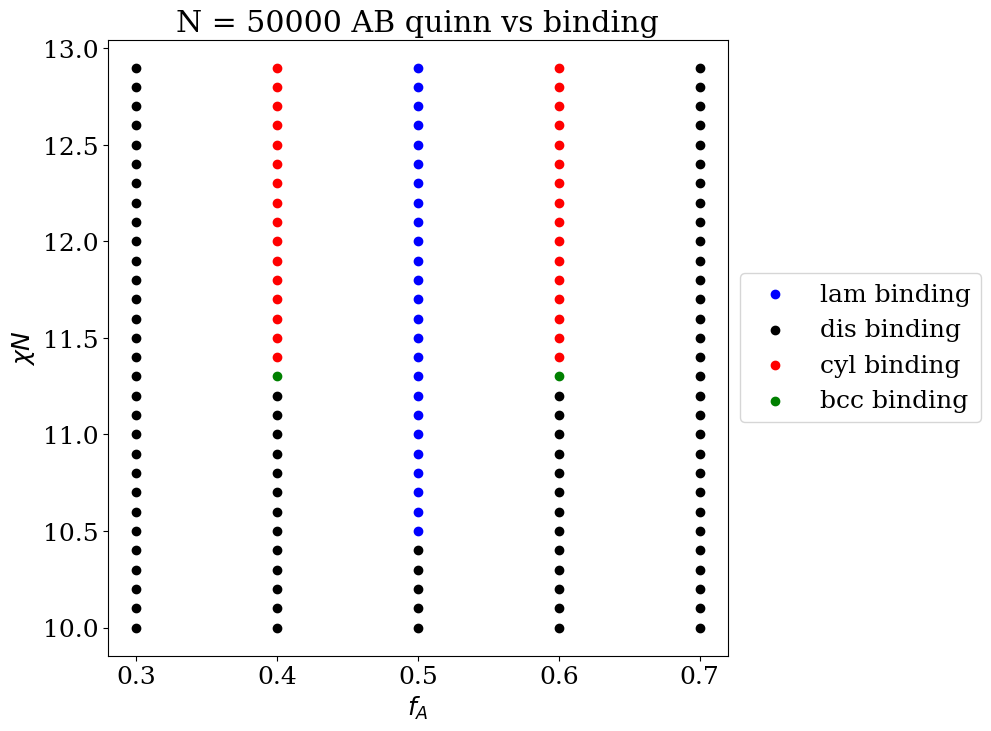

In [22]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


ax.scatter(lam_pnts_b[::2], lam_pnts_b[1::2], label = "lam binding", color = "blue")
ax.scatter(dis_pnts_b[::2], dis_pnts_b[1::2], label = "dis binding", color = "black")
ax.scatter(cyl_pnts_b[::2], cyl_pnts_b[1::2], label = "cyl binding", color = "red")
ax.scatter(bcc_pnts_b[::2], bcc_pnts_b[1::2], label = "bcc binding", color = "green")


ax.scatter(lam_pnts_q[::2], lam_pnts_q[1::2], label = "lam quinn",  color = "blue", marker = "x")
ax.scatter(dis_pnts_q[::2], dis_pnts_q[1::2], label = "dis quinn", color = "black", marker = "x")
ax.scatter(cyl_pnts_q[::2], cyl_pnts_q[1::2], label = "cyl quinn", color = "red", marker = "x")
ax.scatter(bcc_pnts_q[::2], bcc_pnts_q[1::2], label = "bcc quinn",  color = "green", marker = "x")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("N = " + str(N) + " AB quinn vs binding")
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A$")

<Figure size 640x480 with 0 Axes>

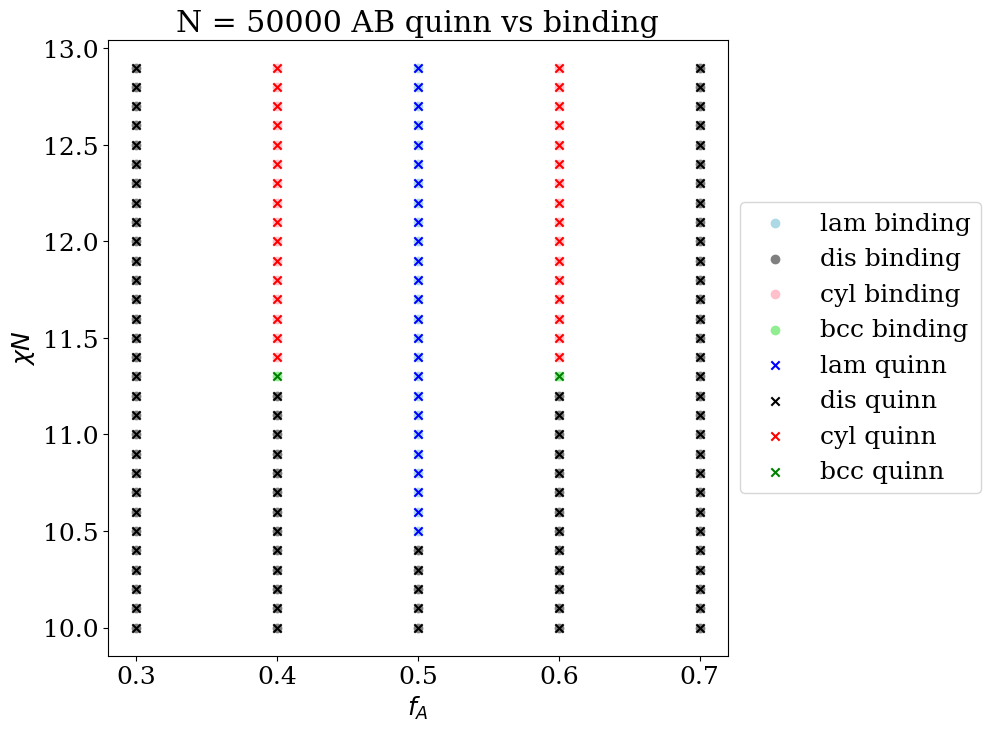

In [23]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


ax.scatter(lam_pnts_b[::2], lam_pnts_b[1::2], label = "lam binding", color = "lightblue")
ax.scatter(dis_pnts_b[::2], dis_pnts_b[1::2], label = "dis binding", color = "grey")
ax.scatter(cyl_pnts_b[::2], cyl_pnts_b[1::2], label = "cyl binding", color = "pink")
ax.scatter(bcc_pnts_b[::2], bcc_pnts_b[1::2], label = "bcc binding", color = "lightgreen")


ax.scatter(lam_pnts_q[::2], lam_pnts_q[1::2], label = "lam quinn",  color = "blue", marker = "x")
ax.scatter(dis_pnts_q[::2], dis_pnts_q[1::2], label = "dis quinn", color = "black", marker = "x")
ax.scatter(cyl_pnts_q[::2], cyl_pnts_q[1::2], label = "cyl quinn", color = "red", marker = "x")
ax.scatter(bcc_pnts_q[::2], bcc_pnts_q[1::2], label = "bcc quinn",  color = "green", marker = "x")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("N = " + str(N) + " AB quinn vs binding")
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A$")

plt.savefig('quinn_bind_AB_comp.png')

<Figure size 640x480 with 0 Axes>

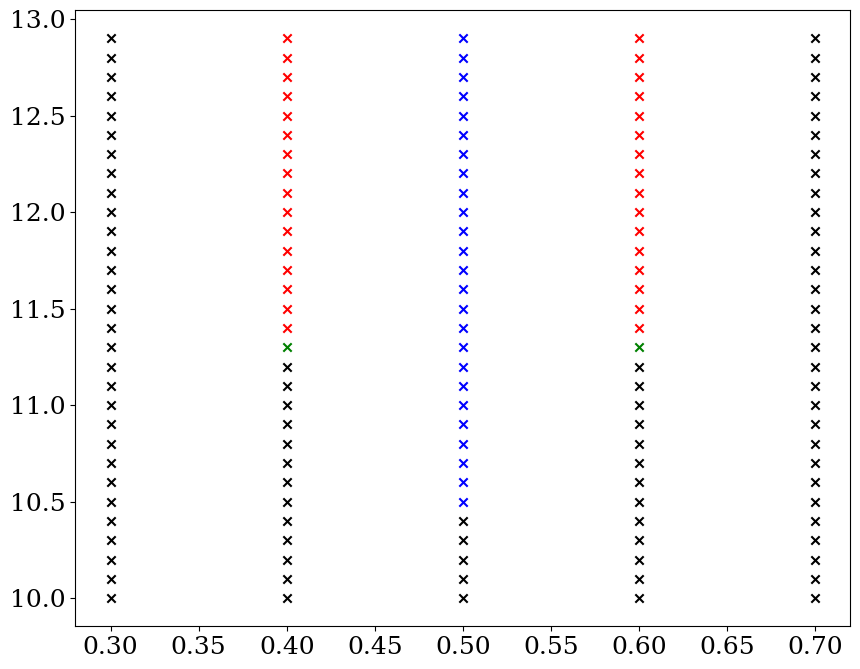

In [17]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


ax.scatter(lam_pnts_q[::2], lam_pnts_q[1::2], label = "lam quinn",  color = "blue", marker = "x")
ax.scatter(dis_pnts_q[::2], dis_pnts_q[1::2], label = "dis quinn", color = "black", marker = "x")
ax.scatter(cyl_pnts_q[::2], cyl_pnts_q[1::2], label = "cyl quinn", color = "red", marker = "x")
ax.scatter(bcc_pnts_q[::2], bcc_pnts_q[1::2], label = "bcc quinn",  color = "green", marker = "x")

In [31]:
# CONCLUSION:
# it is key to have chi/N term in gamma2 in order to get finite negative free energy
# also key to make my gamma 4 negative